## Table of Contents
<a id='contents'></a>

[Python working setup](#pySetup)

[Species accumulation curves](#SAC)

[Turnover diagrams by habitat](#Turnover)

[Ordination by habitat](#NMS)

[PERMANOVA models of available environmental data](#PERMANOVA)  

[Generate environmental data from DEM](#DEM)  
  - [Slope (and a note about GPS vs. DEM elevation data)](#slope)
  - [aspect](#aspect)

[hierarchical clustering of sites](#hierarch)

[Physical Map](#DEMmap)

[Indicator species analysis](#indSpp)

[Mantel tests](#mantel)

[MEM spatial analysis (all points)](#mem)

[Old Forest Sites - a closer look](#ofs)


<a id='pySetup'></a>
### Python working setup

In [31]:
import os
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
import scipy.spatial as sp
import geopandas as gpd
import rasterio
import rasterio.plot
import copy
import random
import math

I did a bit of data cleaning of Ana's raw data, to create the following working dataframe. It has most of what I need up to this point:

In [5]:
specObs = pd.read_pickle('specObs.p')
specObs.head()

,site,parcela,subparcela,PsubP,familia,genero,especie,genusSpecies,habito,elevacion,habitat
1,1,1,1,1.1,Flacourtiaceae,Banara,regia,Flacourtiaceae Banara regia,Árbol,1425,RG
2,1,1,1,1.1,Melastomataceae,Leandra,subseriata,Melastomataceae Leandra subseriata,Arbolito,1413,RG
3,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
4,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
5,1,1,1,1.1,Cecropiaceae,Cecropia,reticulata,Cecropiaceae Cecropia reticulata,Árbol,1413,RG


For all of the analyses conducted so far, I have used the subplot as a basic sampling unit. These are denoted in the PsubP column, where the first number is the plot, and the number after the decimal is a subplot. Together they make a unique identifier. 

From this we can make a general site x species matrix:

In [15]:
smallSpecObs = specObs[['PsubP','genusSpecies']]
bdfDummy = pd.get_dummies(smallSpecObs['genusSpecies'])
bdfDummy.insert(0, 'PsubP', smallSpecObs.PsubP)
bdfDummyGroup = bdfDummy.groupby('PsubP')
subParcelComm = bdfDummyGroup.agg(np.sum)
subParcelComm.head()

,Actinidaceae Saurauia sp. 1,Anacardiaceae Mauria cf. heterophylla,Anacardiaceae Tapirira guianensis,Annonaceae Guatteria cf. megalophylla,Annonaceae Guatteria megalophylla,Annonaceae Guatteria sp.,Annonaceae Rollinia aff. dolichopetala,Annonaceae Rollinia edulis,Annonaceae sp.,Aquifoliaceae Ilex cf. yurumanguinis,...,Theophrastaceae Clavija eggersiana,Theophrastaceae Clavija membranacea,Thymelaeaceae Schoenobiblus daphnoides,Ulmaceae Trema micrantha,Urticaceae Boehmeria caudata,Urticaceae Urera aff. caracasana,Urticaceae Urera baccifera,Urticaceae Urera caracasana,Verbenaceae Aegiphila alba,Violaceae Gloeospermum longifolium
PsubP,,,,,,,,,,,,,,,,,,,,,
1.1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Exploring our data a bit:

In [8]:
specObs.columns

Index(['site', 'parcela', 'subparcela', 'PsubP', 'familia', 'genero',
       'especie', 'genusSpecies', 'habito', 'elevacion', 'habitat'],
      dtype='object')

In [6]:
specObs.shape

(2737, 11)

2737 observations, each one representing a collection of a plant. Lots of plants. How many species observed?

In [10]:
len(specObs.genusSpecies.unique())

343

[back to top](#contents)

<a id="SAC"></a>
### Species accumulation curves

We can split up our site-by-species matrix by habitat, in python:

In [ ]:
aa = specObs[['PsubP', 'habitat']].drop_duplicates()
aa.set_index('PsubP', inplace=True)
bb = pd.concat([aa, subParcelComm], axis=1)
bbGrouped = bb.groupby('habitat')
habs = list(bbGrouped.groups.keys())

for i in habs:
    cc = bbGrouped.get_group(i)
    observed = (cc != 0).any(axis=0).values
    dd = cc.iloc[:,observed]
    dd.drop('habitat', axis=1, inplace=True)
    dd.to_csv(f'{i}_comm.csv')

Now we can use these smaller dataframes to make turnover graphs and do chao estimates. Back to R:

In [4]:
library(vegan)
library(RColorBrewer)
library(repr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



[1] "subParcelComm.csv"
[1] "BC_comm.csv"
[1] "BS_comm.csv"
[1] "CLB_comm.csv"
[1] "RCA_comm.csv"


Warning message in cor(x > 0):
“the standard deviation is zero”


[1] "RG_comm.csv"


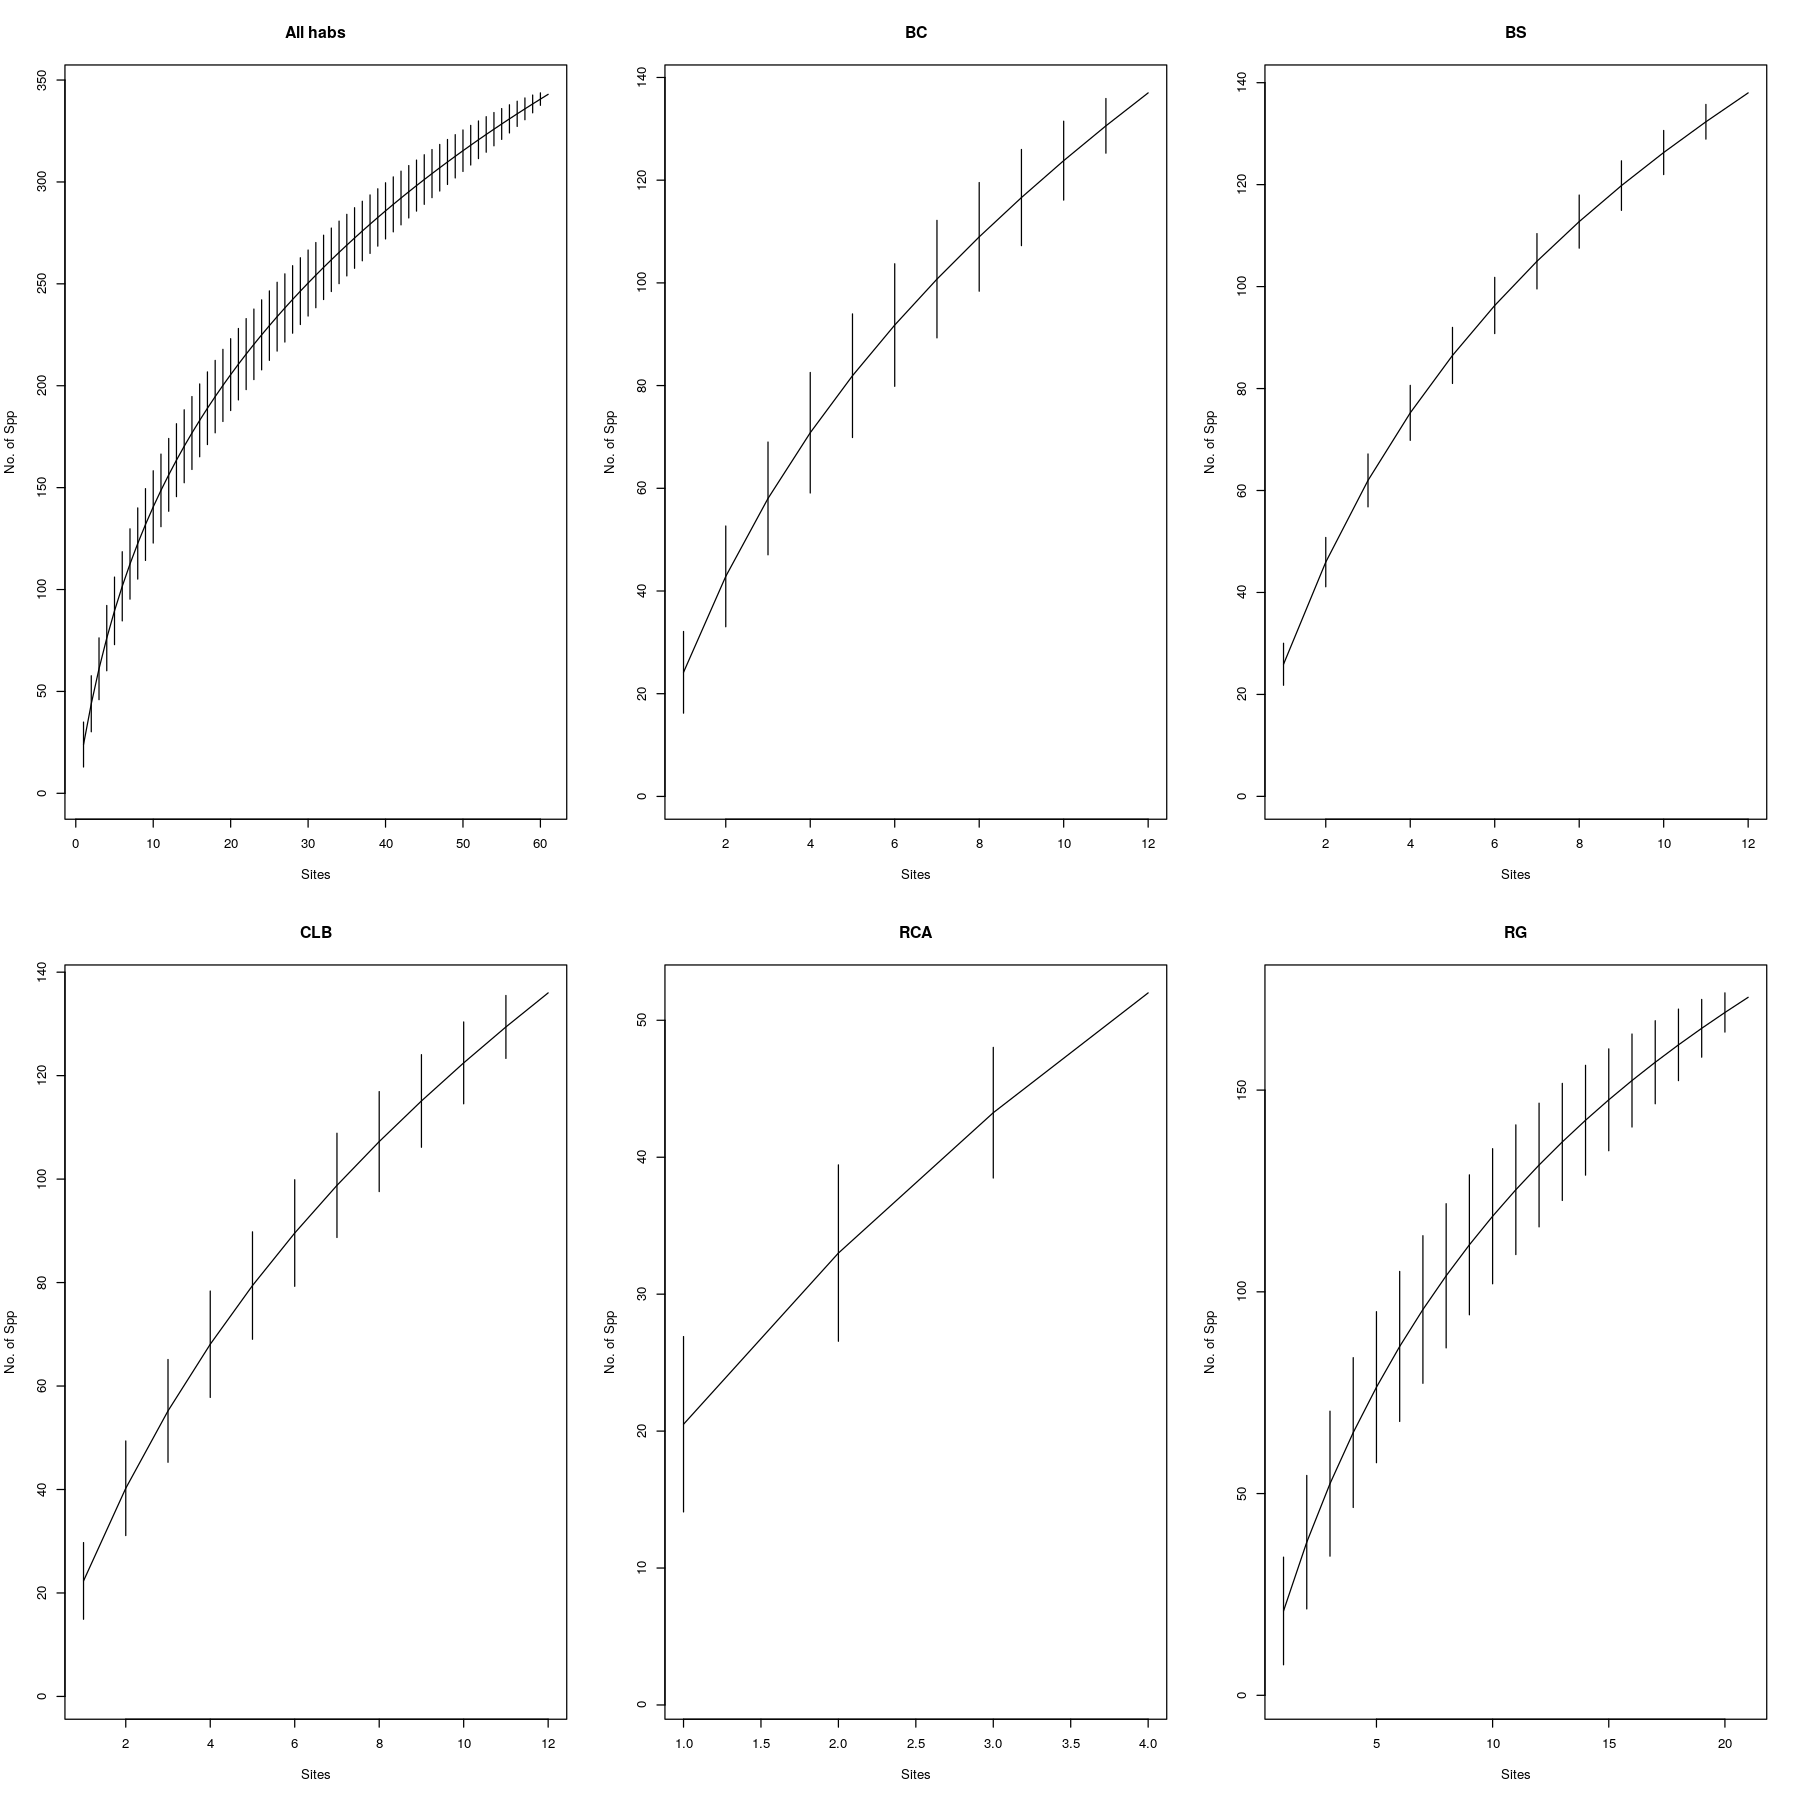

In [7]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2,3))
files <- list.files()
comm <- grep('_comm.csv', list.files())
comms <- files[comm]
comms <- c("subParcelComm.csv", comms)
comtitles <- sub("_comm.csv", "", comms)
comtitles[1] <- "All habs"
j <- 0
for (i in comms){
    j <- j + 1
    comm.i <- read.csv(i, header=TRUE, row.names=1)
    print(i)
    SAC <- specaccum(comm.i, method = "exact")
    plot(SAC, main=comtitles[j], ylab='No. of Spp')
    capture.output(print(paste('Species estimates for', comtitles[j], sep=" ")),
                    file="habSRestimates.txt", append = TRUE)
    capture.output(specpool(comm.i),
                    file="habSRestimates.txt",
                    append = TRUE)
    sacDF <- data.frame(cbind(SAC$richness, SAC$sd), row.names=SAC$sites)
    colnames(sacDF) <- c('richness', 'sd')
    write.csv(sacDF, file=paste(comtitles[j], "SAC.csv", sep="_"))
}

Chao estimators for these:

[back to top](#contents)

<a id='Turnover'></a>
### Turnover diagrams by habitat

Let's check turnover rates in community similarity of these various habitat types. 

In [63]:
specObs = pd.read_pickle('specObs.p')
subParcelComm = pd.read_pickle("subParcelComm.p")
subParcelComm.index = subParcelComm.index.astype('float')
subParcelComm.sort_index(inplace=True)

pts = gpd.read_file('GIS/ana30meterPlots.geojson')
pts.set_index('PsubP', inplace=True)
pts.sort_index(inplace=True)

## sanity check
(pts.index == envOnly.index).all()

True

BC
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BS
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CLB
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RCA
3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RG
4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


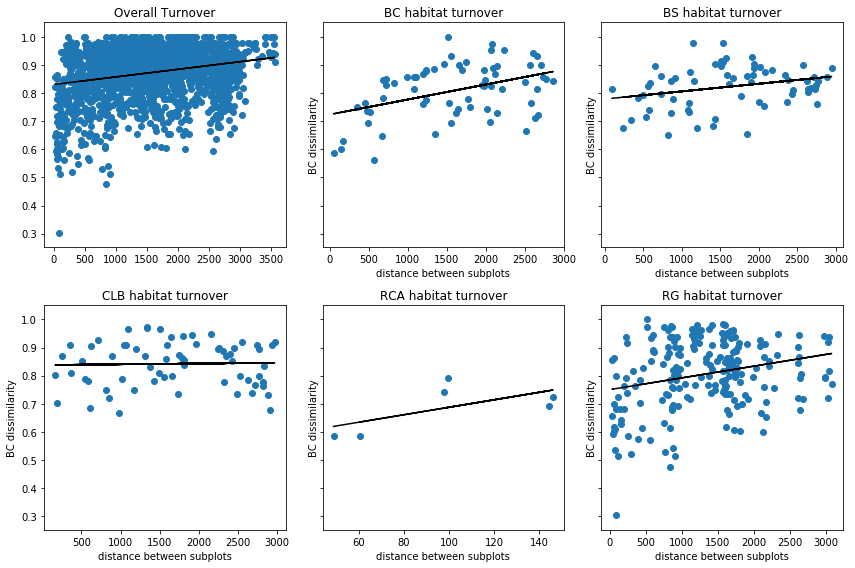

In [64]:
## get our original in there first:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))
axes = axes.flatten()
d = {'X': pts.geometry.x, 'Y': pts.geometry.y}
physDist = sp.distance.pdist(pd.DataFrame(data=d), metric='euclidean')
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
axes[0].scatter(physDist, bcDist)
axes[0].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
axes[0].set_title('Overall Turnover')

## now look at these individually:
soGrouped = specObs.groupby('habitat')
habs = list(soGrouped.groups.keys())

for h,i in enumerate(habs):
    print(i)
    print(h)
    obs_i = soGrouped.get_group(i)
    obs_iE = [ pts.loc[float(a)].geometry.x for a in obs_i.PsubP ]
    obs_iN = [ pts.loc[float(a)].geometry.y for a in obs_i.PsubP ]
    obs_i['E'] = obs_iE
    obs_i['N'] = obs_iN
    subParcelInObs_i = subParcelComm.index.isin(obs_i.PsubP)
    comm_i = subParcelComm[subParcelInObs_i]
    notObserved=~((comm_i == 0).all(axis=0).values)
    comm_i = comm_i.iloc[:,notObserved]
    pts_i = pts.loc[comm_i.index.values]
    iX, iY = pts_i.geometry.x.to_list(), pts_i.geometry.y.to_list()
    spDF_i = pd.DataFrame(np.array([iX, iY]).transpose(), columns=['X','Y'])
    physDist_i = sp.distance.pdist(spDF_i, metric='euclidean')
    bcDist_i = sp.distance.pdist(comm_i, metric='brayCurtis')
    axes[h+1].scatter(physDist_i, bcDist_i)
    X, Y = physDist_i.reshape(-1,1), bcDist_i.reshape(-1,1)
    axes[h+1].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
    axes[h+1].set_xlabel('distance between subplots')
    axes[h+1].set_ylabel('BC dissimilarity')
    axes[h+1].set_title(f'{i} habitat turnover')

plt.tight_layout()

[back to top](#contents)

<a id='NMS'></a>
### Ordination by habitat

Let's see how these habitats separate out, if at all. We'll need to do this in R.

In [27]:
library(vegan)
library(RColorBrewer)

In [28]:
subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]

In [29]:
nms <- metaMDS(sPC, try=40)

Wisconsin double standardization
Run 0 stress 0.2882666 
Run 1 stress 0.3195477 
Run 2 stress 0.2947891 
Run 3 stress 0.2892106 
Run 4 stress 0.292469 
Run 5 stress 0.3178613 
Run 6 stress 0.2936669 
Run 7 stress 0.2897919 
Run 8 stress 0.2892864 
Run 9 stress 0.3106905 
Run 10 stress 0.2951552 
Run 11 stress 0.2897904 
Run 12 stress 0.2909597 
Run 13 stress 0.2897151 
Run 14 stress 0.2882719 
... Procrustes: rmse 0.00530008  max resid 0.02712079 
Run 15 stress 0.2896714 
Run 16 stress 0.2927371 
Run 17 stress 0.2905834 
Run 18 stress 0.2883975 
... Procrustes: rmse 0.01098062  max resid 0.04810461 
Run 19 stress 0.2909603 
Run 20 stress 0.2927886 
Run 21 stress 0.2920623 
Run 22 stress 0.2935624 
Run 23 stress 0.2896132 
Run 24 stress 0.2932293 
Run 25 stress 0.2921688 
Run 26 stress 0.2896941 
Run 27 stress 0.2896659 
Run 28 stress 0.2912579 
Run 29 stress 0.2909597 
Run 30 stress 0.2897274 
Run 31 stress 0.2896175 
Run 32 stress 0.2923796 
Run 33 stress 0.293559 
Run 34 stress 0.288

Stresses look high...check them out a little more closely:

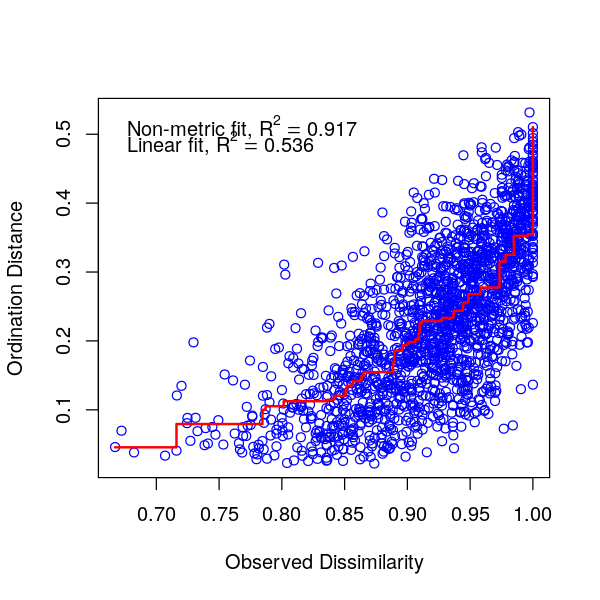

In [32]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(nms)


Not great, but might be useful. Most of the solutions are under 0.3...let's look at the one that was saved:

In [33]:
specObs <- read.csv('specObs.csv')
aa = specObs[c("PsubP","habitat")]
colrs <- brewer.pal(5, "Set1")
nondups <- aa[!duplicated(aa),]
nondups <- nondups[order(nondups$PsubP),]
rownames(nondups) <- NULL
nondups$colorNu <- as.numeric(nondups$habitat)
nondups$colrs <- colrs[nondups$colorNu]
nondups$MDS1 <- nms$points[,'MDS1']
nondups$MDS2 <- nms$points[,'MDS2']
nmsInfo <- nondups

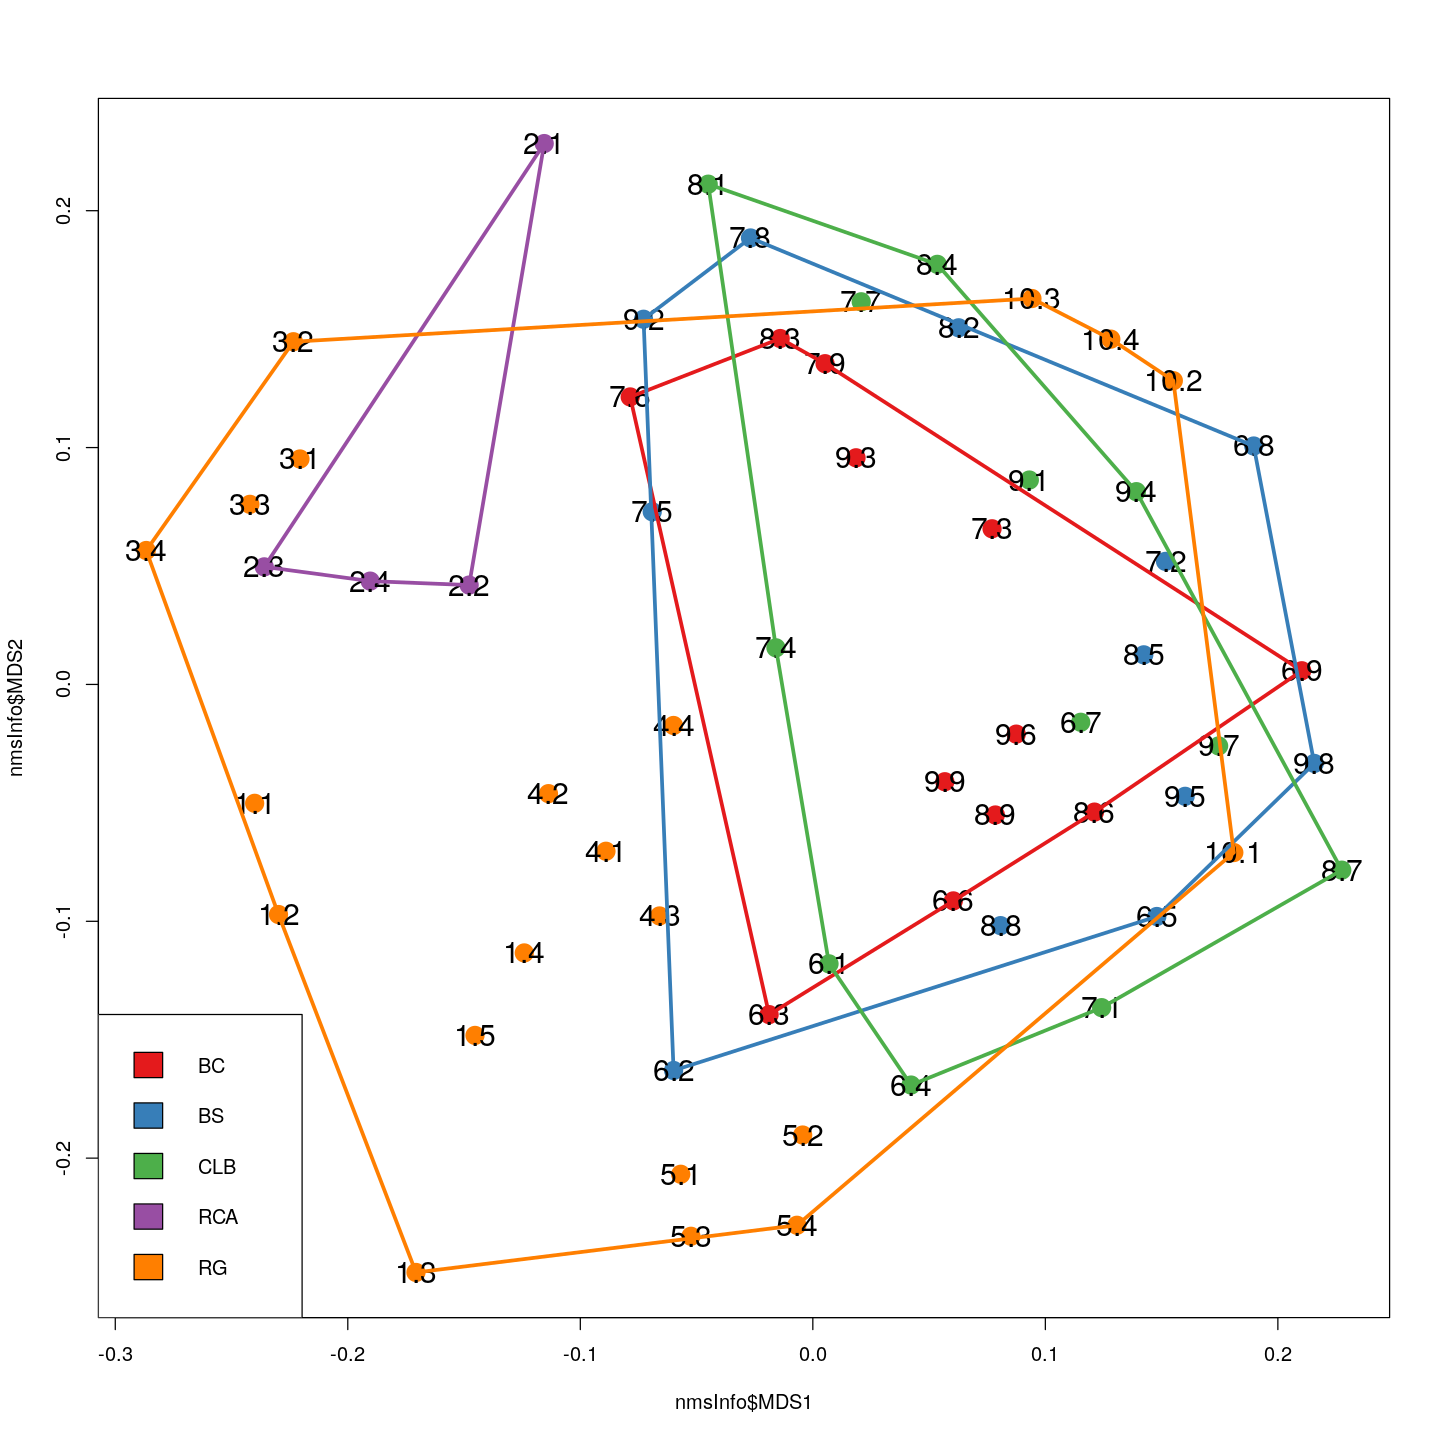

In [40]:
options(repr.plot.width=12, repr.plot.height=12)
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$colrs,
    pch=19,
    cex=2.0,
)
text(nmsInfo$MDS1, nmsInfo$MDS2, nmsInfo$PsubP, cex=1.5)
## add a legend
legend( x='bottomleft',
        legend = c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        col = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        cex = 1.0,
        )
ordihull(nms, nmsInfo$habitat, col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'), lwd=3)


BC - Bosque cerrado  
BS - Bosque secundario  
CLB - Claro de bosque  
RG - regeneración fincas agricultura ganadería  
RCA - Regeneración cañaveral  

<a id='PERMANOVA'></a>

### PERMANOVA models of available environmental data

Let's look at the influence of elevation and habitat type on our dissimilarity matrix. For the moment, the only directly observed data I have is habitat type (RCA, RG, CLB, etc), and elevation. 

In [44]:
library(vegan)

envOnly <- read.csv('envOnly.csv')
envOnly <- envOnly[order(envOnly$PsubP),]

subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]
sPC <- sPC[order(as.numeric(rownames(sPC))),]

adonis(sPC ~ envOnly$elevacion*envOnly$habitat)


Call:
adonis(formula = sPC ~ envOnly$elevacion * envOnly$habitat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
envOnly$elevacion                  1    1.8357 1.83572  5.9572 0.07945  0.001
envOnly$habitat                    4    4.1072 1.02679  3.3321 0.17776  0.001
envOnly$elevacion:envOnly$habitat  4    1.4468 0.36170  1.1738 0.06262  0.116
Residuals                         51   15.7157 0.30815         0.68017       
Total                             60   23.1054                 1.00000       
                                     
envOnly$elevacion                 ***
envOnly$habitat                   ***
envOnly$elevacion:envOnly$habitat    
Residuals                            
Total                                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Habitat type is having a strong influence here, and elevation is having a lesser but statistically significant effect. There doesn't seem to be a ton of interaction there, or at least the story is too noisy to be statistically significant. If we reverse the terms (habitat and elevation, not shown) we get similar results. 

[back to top](#contents)

<a id="DEM"></a>

### Generate environmental data from DEM

We can get a bit more information using a digital elevation model (DEM) for the area. I used a raster from the [ASTER GDEM2 project](https://asterweb.jpl.nasa.gov/gdem.asp) to generate slope and aspect data for each subparcel site. This is the topography map that is the background for the [physical map](#DEMmap) below, The DEM was clipped to roughly the bounding box of Los Cedros, and I used the in-house tools in QGIS (QGIS v3.4.11-Madeira, OSGEO v3.7.1) to generate slope and aspect data (`Processing >>> Toolbox >>> Raster terrain analysis >>> Aspect / Slope`). We'll use the [Rasterio package](https://github.com/mapbox/rasterio) in python to take a look at these, which is basically a nice wrapper for gdal tools for rasters.

The slope and aspect maps look like this:

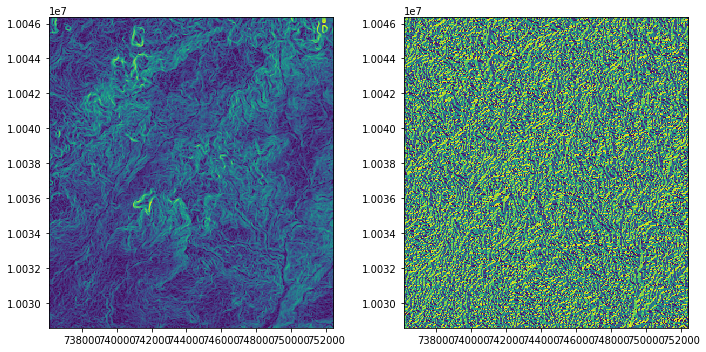

In [73]:
slopeRast = rasterio.open("GIS/lcSlope.tif")
aspectRast = rasterio.open("GIS/lcAspect.tif")
__, axes = plt.subplots(1,2, figsize=(10,5))
rasterio.plot.show(slopeRast, ax=axes[0])
rasterio.plot.show(aspectRast, ax=axes[1])
plt.tight_layout()

<a id='slope'></a>
#### Slope (and a note about GPS vs. DEM elevation data)

The z value on this map is slope in degrees, I believe. We can extract the z value for the pixels where we have subplots.

In [18]:
## get geopanda of subparcel points:
pts = gpd.read_file('GIS/ana30meterPlots.geojson')
pts.set_index('PsubP', inplace=True)
pts.sort_index(inplace=True)

## add the elevation as measured from the GPS's, in ana's excel sheets:
envOnly = pd.read_csv('envOnly.csv')
envOnly.set_index('PsubP', inplace=True)
envOnly.sort_index(inplace=True)

(pts.index == envOnly.index).all()

True

In [20]:
## get rasters
slopeRast = rasterio.open("GIS/lcSlope.tif")
aspectRast = rasterio.open("GIS/lcAspect.tif")

Our function for grabbing Z values from rasters:

In [19]:
## function for grabbing z values from rasters
def getZ(xx,yy,robj):
    robjR = robj.read(1)
    rc = robj.index(xx,yy)
    return(robjR[rc])

Get slope for all of our points, and add this to our environmental dataframe. We'll also get our predictions for the elevation of a site by the DEM, to compare with the GPS data from Ana's study. 

In [24]:
## slope
envOnly['slope'] = [ getZ(i.x, i.y, slopeRast) for i in pts.geometry ]
## add DEM-predictions of elevation
envOnly['DEM'] = [ getZ(i.x, i.y, dem) for i in pts.geometry ]

## take a look
envOnly.head(10)

,elevacion,habitat,slope,DEM
PsubP,,,,
1.1,1413,RG,21.501858,1325
1.2,1398,RG,15.726591,1411
1.3,1380,RG,28.038858,1411
1.4,1370,RG,9.895795,1429
1.5,1362,RG,3.489236,1428
2.1,1189,RCA,25.335262,1232
2.2,1200,RCA,20.097029,1200
2.3,1201,RCA,29.561605,1231
2.4,1226,RCA,28.344837,1251


Just curious, how well do our values from the GPS and the DEM line up?

Text(0, 0.5, 'DEM Elevation')

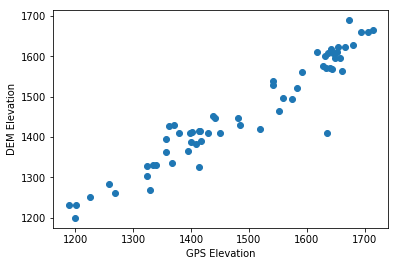

In [25]:
aa = plt.scatter(envOnly['elevacion'], envOnly['DEM'])
plt.gca().set_xlabel('GPS Elevation')
plt.gca().set_ylabel('DEM Elevation')

Well, not a perfect fit, but pretty good. Seems like the GPS usually estimates a little higher than the DEM. Anyway...

<a id='aspect'></a>
#### Aspect

Aspect is a little trickier. We can extract it from the aspect raster in the same way:

In [28]:
aspectRast = rasterio.open("GIS/lcAspect.tif")
envOnly['aspect'] = [ getZ(i.x, i.y, aspectRast) for i in pts.geometry ]

But then we have to process it a bit. The reason for this is that aspect is non-linear, north is approached from two very different maxima, 0 and 360 degrees. Thus two values that appear maximally different (say, 10° and 350°) are actually very close in their aspect. So we'll separate it into northern exposure and eastern exposure. These will be the sine and cosine of our compass heading, after a bit of conversion. This will give us values ranging from -1 to 1 for both eastern exposure and northern exposure. A value of 1 for eastern exposure means the plot is facing purely to the east, etc.

The conversion: since compass values start at north (0°/360° compass bearing) and increase as they move clockwise. In contrast, traditional mathematical functions measure angles as they differ from the x-axis (east, or 90° compass-bearing axis), and the angle increases as it diverges counter-clockwise, the opposite of compass bearings. To use existing sine/cosine functions, we'll have to do these conversions on the aspect data.

So our conversion will be `θ = -(compassBearing - 90)`, along with a conversion to radians for the math package. The we decompose this into two variables, eastern exposure and northern exposure:

In [32]:
angles = [ -(H - 90) for H in envOnly['aspect'] ]

## then get the cos (southern exposure) and sin (northern exposure) 

envOnly['exposeE'] = [ math.cos(math.radians(i)) for i in angles ]
envOnly['exposeN'] = [ math.sin(math.radians(i)) for i in angles ]


So now our data looks like this:

In [33]:
envOnly.head(30)

,elevacion,habitat,slope,DEM,aspect,exposeE,exposeN
PsubP,,,,,,,
1.1,1413,RG,21.501858,1325,73.622154,0.959423,0.281971
1.2,1398,RG,15.726591,1411,228.535767,-0.749369,-0.662152
1.3,1380,RG,28.038858,1411,72.854744,0.955560,0.294795
1.4,1370,RG,9.895795,1429,55.796314,0.827044,0.562137
1.5,1362,RG,3.489236,1428,78.269325,0.979114,0.203312
2.1,1189,RCA,25.335262,1232,130.563461,0.759686,-0.650290
2.2,1200,RCA,20.097029,1200,274.145081,-0.997384,0.072282
2.3,1201,RCA,29.561605,1231,305.870209,-0.810346,0.585951
2.4,1226,RCA,28.344837,1251,98.652718,0.988618,-0.150445


In [60]:
#envOnly.to_csv("envOnly.csv")

[back to top](#contents)

<a id="hierarch"></a>
### Hierarchical clustering of sites
    
Let's see if this clustering we see in the NMS is noticeable with a hierarchical clustering method, as another way of tracking similarities among sites in species composition.

In [19]:
library(stats)
library(vegan)

subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]
## we need a distance matrix, BC
## does vegan give us what we need?
sPCBray <- vegdist(sPC)
sPC.ward <- hclust(sPCBray, method='ward.D2')

A function to show our tree, along with a physical map of the points:

In [20]:
makeClustMap <- function(tree, k, labels=NULL){
    envOnly <- read.csv('envOnly.csv')
    pts <- read.csv('pts.csv', row.names='PsubP')
    pts$PsubP <- as.numeric(rownames(pts))
    pts <- pts[,c(3,1,2)]
    rownames(pts) <- NULL
    require(stats)
    ## get habitat type labels for tree
    if (is.null(labels)){lab <- NULL} else {
        if (labels=='hab'){
        lab <- vector(length = length(tree$labels))
        for (i in 1:length(tree$labels)){
            ind <- which(envOnly$PsubP==tree$labels[i])
            lab[i] <- as.character(envOnly$habitat[ind])
    }}}
    par(mfrow=c(1,2))
    plot(tree, labels=lab)
    clustGroups <- rect.hclust(tree, k=k, border=1:k)
    cmem <- vector(length=k)
    PsubP <- vector()
    gr <- vector()
    for (i in 1:k){
        cmem.i <- as.numeric(attr(clustGroups[[i]], "names"))
        PsubP <- c(PsubP, cmem.i)
        gr <- c(gr, rep(i, length(cmem.i)))
        }
    cGroup <- data.frame(cbind(PsubP, gr))
    cGroup <- cGroup[order(cGroup$PsubP),]
    clsp <- base::merge(pts, cGroup)
    clsp <- base::merge(clsp, envOnly)
    shapes <- vector(length=nrow(clsp))
    shapes[clsp$habitat == 'BC'] <- 19
    shapes[clsp$habitat == 'BS'] <- 21
    shapes[clsp$habitat == 'CLB'] <- 22
    shapes[clsp$habitat == 'RCA'] <- 17
    shapes[clsp$habitat == 'RG'] <- 23
    plot(x=pts$X,
        y=pts$Y,
        col=clsp$gr,
        xlab='',
        ylab='',
        asp=1,
        cex=2,
        lwd=2,
        pch=shapes,
        )
    legend('bottomright',
        legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        pch=c(19, 21, 22, 17, 23)
    )
    legend('bottomleft',
        legend=1:k,
        pch=c(15),
        col=1:k,
        title='ClusterGroup')
    return(clsp)
    }


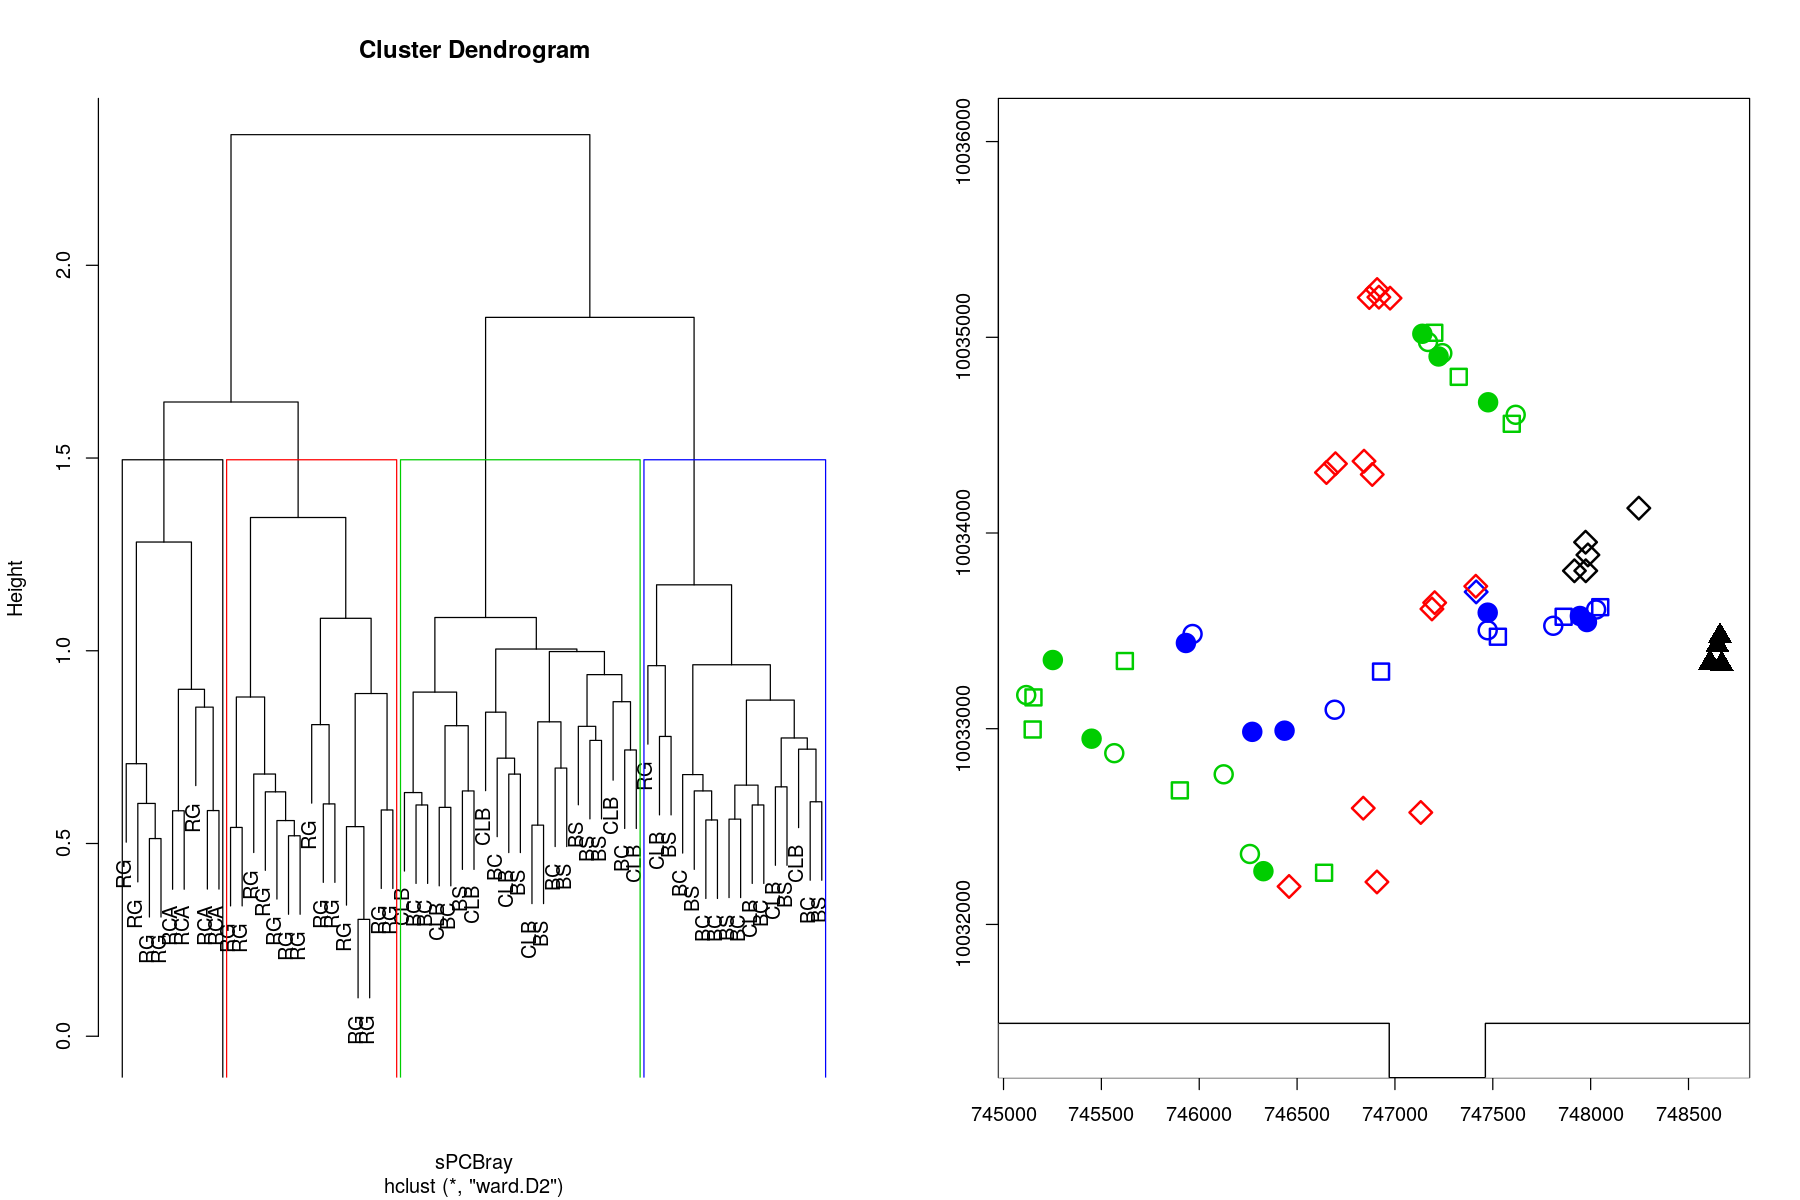

In [21]:
options(repr.plot.width=15, repr.plot.height=10)
k <- 4 ## number of groups 
bb <- makeClustMap(sPC.ward, k=k, labels='hab')
legend('bottomright',
    legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
    pch=c(19, 21, 22, 17, 23)
)

legend('bottomleft',
    legend=1:k,
    pch=c(15),
    col=1:k,
    title='ClusterGroup')


The jupyter plotter isn't really handling that well. PNG's:

<img src="hclust4groups.png">

Just for reference, this is the tree with unique Plot/subplot identifiers:

<img src='hclust_4groups_PsubP.png' width="1000">

In the tree above, the RCA plots are again by themselves in a group, with a few RG plots. The closest "relative" of these RCA plots is a section that contains the majority of the RG plots, group 2, in red. The other two groups (groups 3/green and 4/blue) form a major branch, and contain most of the secondary and closed forest, and the natural gaps. Interesting that the gaps cluster in with the forest so distinctly from the regen sites. The split in the forest groups, 3 & 4, may be showing the difference between riparian and upland sites, but needs a closer look. 

The second graph is a physical map, reflecting the distances among the points. 

[back to top](#contents)

<a id='DEMmap'></a>

### Physical Map

Let's put an elevation and water (rivers and stream) map under these plots. We'll use python here, as the geopandas library is way easier to use than the whole mess of R geospatial packages. 

#### Cleaning the raw data
The first step is a bit of cleanup from the data I've received from Ana. Location information for all 30m-diameter plots was given to me from Ana in a file called "GPSpointsCedros.xls". For the points to make sense from this file, I had to exchange the N and E columns, I think they were switched/mislabeled, and that the easting column is off by 10^7 meters. They appear to be in a UTM CRS, but not the zone 17S that I typically use for the LC area. I think they are probably in UTM Zone 17N, but not sure. Swapping the N/E columns and adding 10^7 meters seems to fix the problem. Following this, I imported the spreadsheet into QGIS for a visual check. One subplot, 2.4 seemed especially off to Ana, as it was outside the reserve. Dropping the northing on this plot exactly 1 km to the south put it right back into the cluster of other Parcel 2 subplots, so that is my guess on what happened there. These points were exported it as geojson, which we can turn into a geopanda here:


In [5]:
anaPt = gpd.read_file('GIS/ana30meterPlots.geojson')
## our cluster info is here:
cGroup = pd.read_csv("cGroup.csv")
## add this cluster info in
anaPt = anaPt.merge(cGroup, on="PsubP")
## make a vector for coloring the clustering results:
cdik={
1:"k",
2:"r",
3:"g",
4:"b"
}
anaPt['clustCols'] = [ cdik[i] for i in anaPt.gr ]
## where is our habitat data?:
envOnly = pd.read_csv('envOnly.csv')
anaPt = anaPt.merge(envOnly, on="PsubP")
## set the habitat symbol
msym_dik={
'BC':'o',
'BS':'p',
'CLB':'s',
'RCA':'^',
'RG':'D',
}
anaPt['habSyms'] = [ msym_dik[i] for i in anaPt.habitat ]


That seems to work alright. Now we can use this as our point layer for the plots. But we can get a few other layers that I have handy for los Cedros also - a DEM (elevation map), a polygon on LC boundaries, and a map of streams and rivers of los Cedros.

In [11]:
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
dem = rasterio.open("GIS/anaPlotDEM.tif")
paths = gpd.read_file('GIS/PathsLC.geojson')

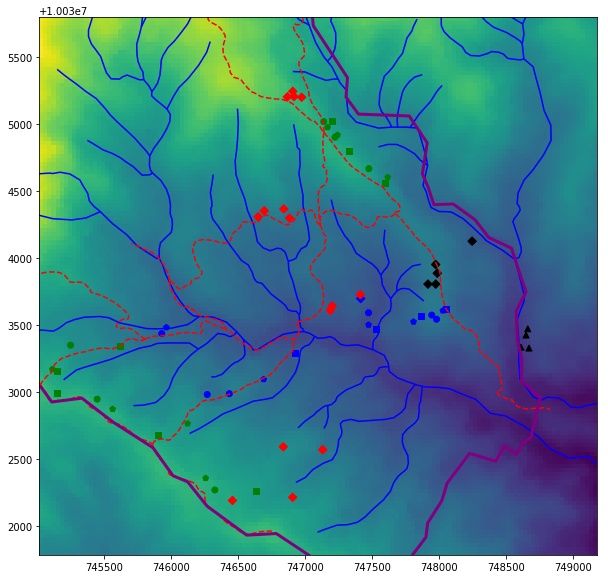

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
for i in anaPt.habitat.unique():
    anaPtI = anaPt[anaPt['habitat'] ==  i].reset_index()
    anaPtI.plot(color=anaPtI.clustCols,
                marker=anaPtI.habSyms[0],
                ax=ax)

hydro.plot(color='Blue', ax=ax)
paths.plot(color='red', linestyle='--', ax=ax)
lcPoly.boundary.plot(color='purple', linewidth=3, ax=ax)
rasterio.plot.show(dem, ax=ax)

Will make a legend separately, can't seem to make it work in python or R easily right now. Colors correspond to the hierarchical clustering results graphic above: 

1=black  
2=red  
3=green  
4=blue  

Shapes correspond to the succession state/habitat: 

BC = circles  
BS = pentagons  
CLB = squares  
RCA = triangles  
RG = diamonds  

Boundaries of the reserve are purple.

[back to top](#contents)

<a id='indSpp'></a>

### Indicator species analysis

Let's look to see if we pick up any obvious indicator species for either the habitat types (clearing, bosque secondario, regenerating finca sites, etc) or for our clustering results. Back in R:

In [1]:
library(indicspecies)

Loading required package: permute



In [11]:
## our community matrix...
comM <- read.csv('subParcelComm.csv')
rownames(comM) <- comM$PsubP

## general plant observation dataframe
specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
rownames(habs) <- NULL

## and our cluster groups:
cldf <- read.csv('cGroup.csv')

## make sure they are the same order
habs <- habs[order(habs$PsubP),]
comM <- comM[order(comM$PsubP),]
cldf <- cldf[order(cldf$PsubP),]
all(habs$PsubP == comM$PsubP)
all(habs$PsubP == rownames(comM))
all(cldf$PsubP == rownames(comM))

## now we can make a vector of our habs dataframe:
habsV <- habs$habitat
clV <- cldf$gr

## clean up extra column of com matrix, careful with this
comM <- comM[,-1] ## get rid of PsubP

[1] TRUE

[1] TRUE

[1] TRUE

In [12]:
habIndSpp <- multipatt(comM, habsV, func = 'r.g', control=how(nperm=9999))

clustIndSpp <- multipatt(comM, clV, func = 'r.g', control=how(nperm=9999))

In [13]:
summary(habIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 24 
 Number of species associated to 1 group: 20 
 Number of species associated to 2 groups: 3 
 Number of species associated to 3 groups: 1 
 Number of species associated to 4 groups: 0 

 List of species associated to each combination: 

 Group BC  #sps.  1 
                              stat p.value  
Moraceae.Pseudolmedia.rigida 0.423  0.0332 *

 Group BS  #sps.  3 
                                    stat p.value  
Rubiaceae.Psychotria.paeonia       0.478  0.0153 *
Lauraceae.Persea.pseudofasciculata 0.432  0.0351 *
Myrtaceae.Myrcia.aff..aliena       0.425  0.0337 *

 Group CLB  #sps.  1 
                                    stat p.value  
Lauraceae.Endlicheria.cf..chalisea 0.431  0.0315 *

 Group RCA  #sps.  11 
                                          stat p.value    
Boraginaceae.Cordia.colombiana    

In [14]:
summary(clustIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 48 
 Number of species associated to 1 group: 32 
 Number of species associated to 2 groups: 16 
 Number of species associated to 3 groups: 0 

 List of species associated to each combination: 

 Group 1  #sps.  9 
                                         stat p.value    
Boraginaceae.Cordia.colombiana          0.661  0.0001 ***
Melastomataceae.Meriania.tomentosa      0.641  0.0001 ***
Actinidaceae.Saurauia.sp..1             0.545  0.0002 ***
Cyatheaceae.Cyathea.halonata            0.458  0.0037 ** 
Fab.Caesalpiniaceae.Senna.dariensis     0.449  0.0054 ** 
Moraceae.Ficus.caldasiana               0.420  0.0210 *  
Melastomataceae.Leandra.subseriata      0.370  0.0167 *  
Melastomataceae.Miconia.aff..brevitheca 0.368  0.0221 *  
Staphyleaceae.Turpinia.occidentalis     0.346  0.0425 *  

 Group 2  #sps.  5 
   

[back to top](#contents)

<a id='mantel'></a>

### Mantel tests

Let's check the estimations of spatial autocorrelation in the plant community with mantel correlograms/tests.

In [41]:
library('vegan')
library('ecodist')

pts <- read.csv('pts.csv', row.names='PsubP')

physdist <- vegdist(pts, method='euclidean')
## make the community dissimilarity matrix
bb <- read.csv('subParcelComm.csv')
bb <- bb[order(bb$PsubP),]
row.names(bb) <- bb$PsubP
bb <- bb[,-1]
all(aa$PsubP == rownames(bb))
braydist <- vegdist(bb, method='bray')
## do the global test:
global_mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test
global_mant_test 

[1] TRUE

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.2377790  0.0001000  1.0000000  0.0001000  0.2013864  0.2722124

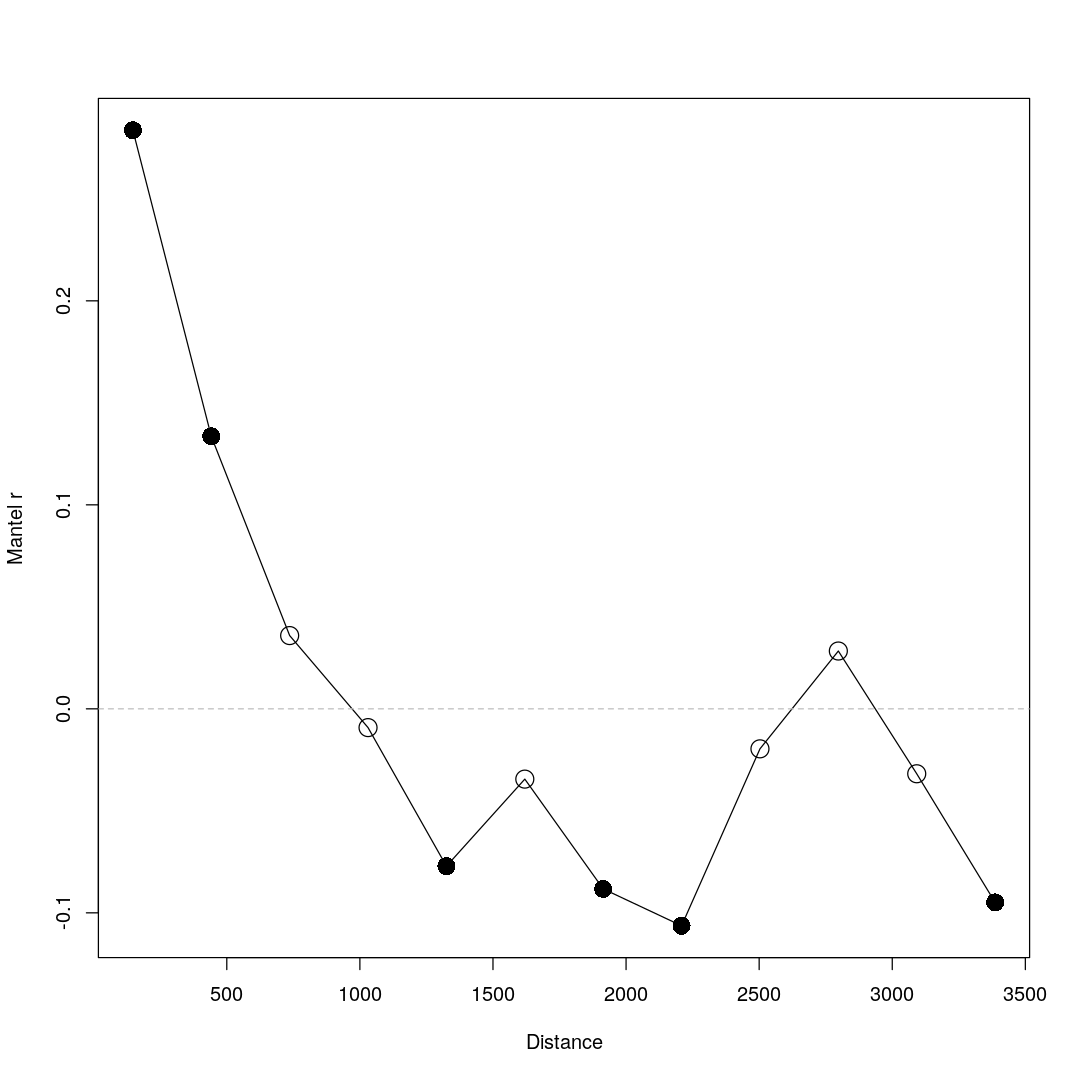

In [42]:
## correlogram
options(repr.plot.width=9, repr.plot.height=9)
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)

Okay w

In [43]:
getDists <- function(comfile, physfile='pts.csv'){
    comM <- read.csv(comfile, row.names=1)
    comM <- comM[order(as.numeric((rownames(comM)))),]
    spM <- read.csv(physfile, row.names=1)
    spM <- spM[order(rownames(spM)),]
    physdist <- vegdist(spM, method='euclidean')
    spM <- spM[rownames(spM)%in%rownames(comM),]
    spM <- spM[order(as.numeric((rownames(spM)))),]
    if(all(rownames(spM) == rownames(comM))){
        physdist <- vegdist(spM, method='euclidean')
        braydist <- vegdist(comM, method='bray')
        return(list(braydist, physdist))
        } else {print("something doesn't fit right")}
    }


In [55]:
getDists <- function(comfile, physfile='finalReport2012Coords.csv'){
    comM <- read.csv(comfile, row.names=1)
    comM <- comM[order(as.numeric((rownames(comM)))),]
    spM <- read.csv('finalReport2012Coords.csv')[,-2]
    spM <- spM[order(spM$PsubP),]
    rownames(spM) <- spM$PsubP
    spM <- spM[,-1]
    physdist <- vegdist(spM, method='euclidean')
    spM <- spM[rownames(spM)%in%rownames(comM),]
    spM <- spM[order(as.numeric((rownames(comM)))),]
    if(all(rownames(spM) == rownames(comM))){
        physdist <- vegdist(spM, method='euclidean')
        braydist <- vegdist(comM, method='bray')
        return(list(braydist, physdist))
        }
    else{print("something doesn't fit right")}
    }


[1] "BC_comm.csv"
[1] "BS_comm.csv"
[1] "CLB_comm.csv"
[1] "RCA_comm.csv"
[1] "RG_comm.csv"


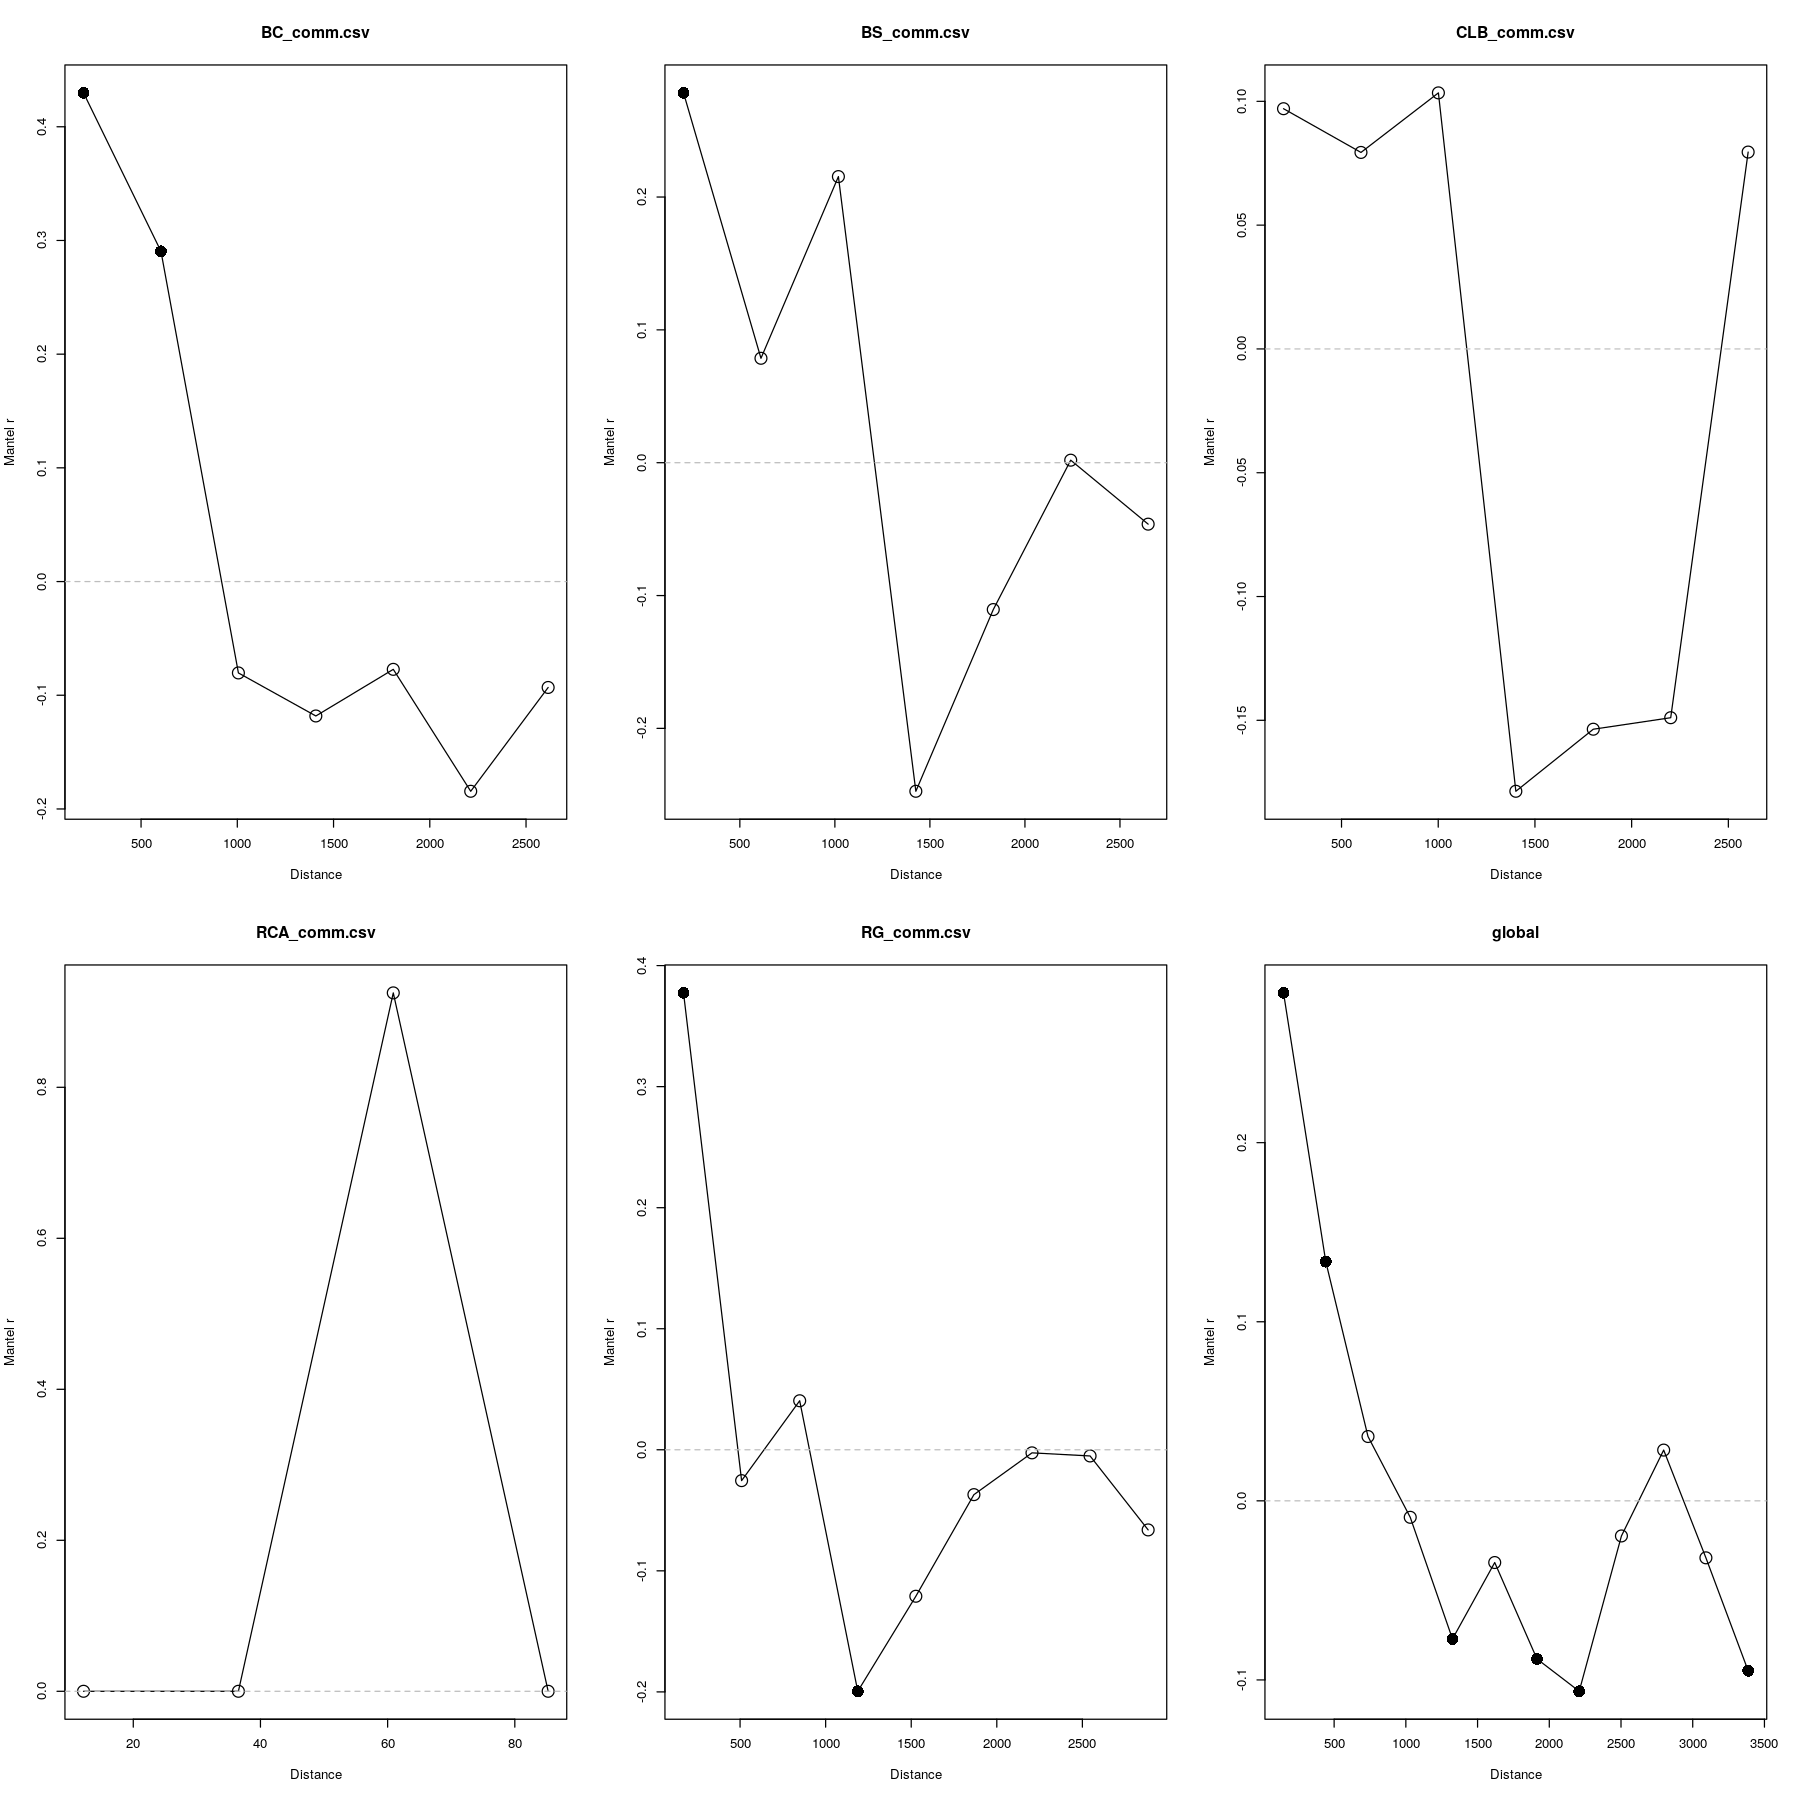

In [44]:
options(repr.plot.width=15, repr.plot.height=15)

## filenames
comms <- c('BC_comm.csv', 'BS_comm.csv', 'CLB_comm.csv', 'RCA_comm.csv', 'RG_comm.csv')
## start df
all_mant_test  <- global_mant_test

## test individually
par(mfrow=c(2,3))
for (i in 1:length(comms)){
    print(comms[i])
    dists.i <- getDists(comms[i])
    cgram.i <- mgram(dists.i[[1]], dists.i[[2]]) ## correlogram object
    plot(cgram.i, main = comms[i] )
    mant_test.i <- mantel(dists.i[[1]] ~ dists.i[[2]], nperm = 10000) ## overall test
    all_mant_test <- rbind(mant_test.i, all_mant_test)
}
plot(cgram, main = "global" )


In [47]:
rownames(all_mant_test) <- c(rev(comms), "global")
all_mant_test[c(5,4,3,2,1,6),]

,mantelr,pval1,pval2,pval3,llim.2.5%,ulim.97.5%
BC_comm.csv,0.43360085,0.0030,0.9971,0.0030,0.3453213,0.5027305
BS_comm.csv,0.28107333,0.0322,0.9679,0.0329,0.1760572,0.3930036
CLB_comm.csv,0.03913118,0.3428,0.6573,0.7462,-0.1390429,0.1956787
RCA_comm.csv,0.63448996,0.2933,0.7495,0.3385,0.5470088,0.9820520
RG_comm.csv,0.25342715,0.0062,0.9939,0.0062,0.1828187,0.3481677
global,0.23777902,0.0001,1.0000,0.0001,0.2013864,0.2722124


The RCA plots have a negative trend in autocorrelation - there is a homogenizing effect somewhere on them, plots that are far away are more similar that you would expect. Bosques cerrados are highly positively autocorrelated, the most autocorrelated type of the habitat in the system.

We can take a look at how the old forest sites behave as group, also:

In [46]:
options(repr.plot.width=8, repr.plot.height=8)

specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
## order by site
habs <- habs[order(habs$Psub),]
rownames(habs) <- NULL
## find old forest subparcels
PsubPoldForest <- habs$habitat != 'RCA' & habs$habitat != 'RG'

aa <- read.csv('finalReport2012Coords.csv')[,-2]
aa <- aa[order(aa$PsubP),]
rownames(aa) <- aa$PsubP
aa <- aa[,-1]

bb <- read.csv('subParcelComm.csv')
bb <- bb[order(bb$PsubP),]
rownames(bb) <- bb$PsubP

all(habs$PsubP == aa$PsubP)
all(habs$PsubP == bb$PsubP)
## subset these:
aa <- aa[PsubPoldForest,]
bb <- bb[PsubPoldForest,]
all(rownames(aa) == rownames(bb))

[1] TRUE

[1] TRUE

[1] TRUE

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.3764229  0.0001000  1.0000000  0.0001000  0.3236591  0.4347705

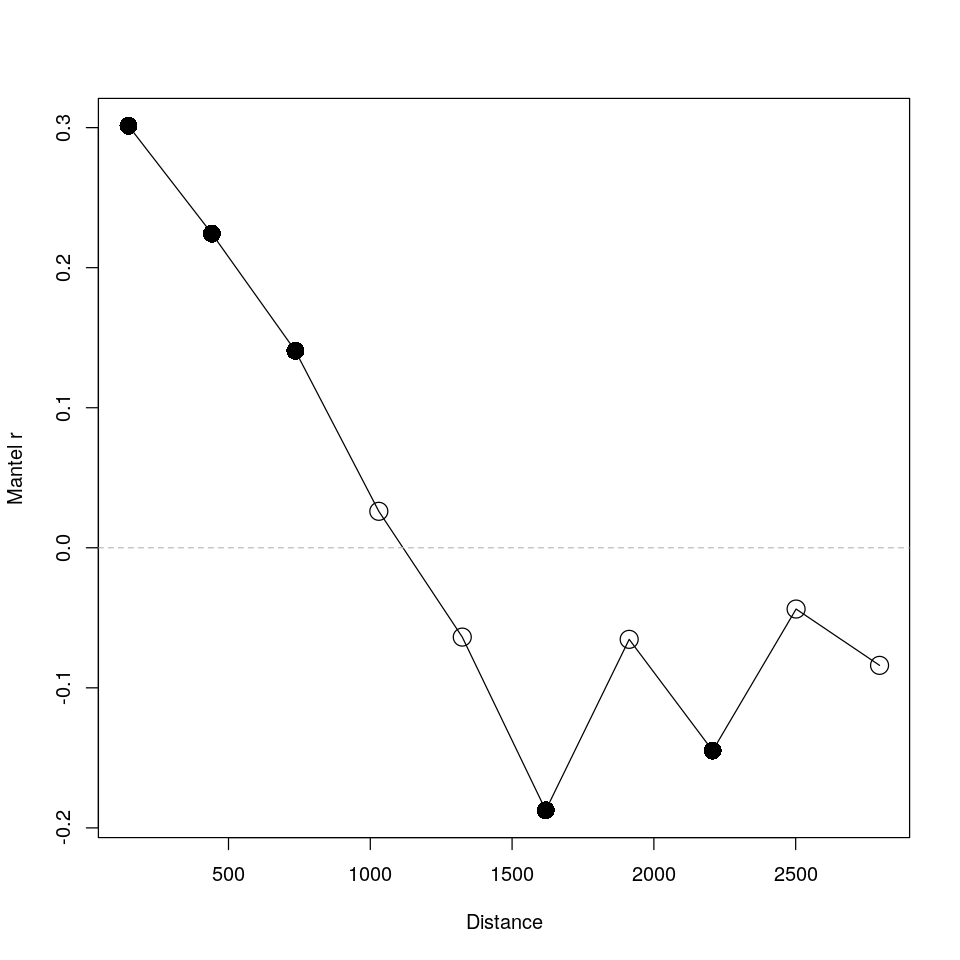

In [71]:
## make dist objects
physdist <- vegdist(aa, method='euclidean')
braydist <- vegdist(bb, method='bray')
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)
mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test
mant_test

When we subset to just the old forest subplots, there are clear signs of positive autocorrelation until ~1000 m. Following this, we again find some sort of homogenizing effect in 1500-2200 m. I'd guess the negative autocorrelation has to do with the layout of the plots: many of the plots are clustered, and the clusters are ~1000 m apart. This may also have something to do with the locations of the two types of forest - because of elevation the two forest types may be coupled (and therefore different) on a pretty local spatial scale, but once enough distance is covered, and the valleys/ridges are scaled, the test encounters similar habitat again. Not sure. But we can try to look a little closer with PCNMs. 

[back to top](#contents)

<a id="mem"></a>
### MEM spatial analysis (all points)

Let's look at the spatial patterns with a more refined tool than the mantel tests. I think of mantel tests as sledge hammers: if there is an obvious spatial pattern going on in your system, take a swing with a mantel's R correlogram and you may hit it. But here we have a different family of approaches, [MEM](https://cran.r-project.org/web/packages/adespatial/vignettes/tutorial.html). 

<img src="MEMDiagram.png">

(Image from the tutorial linked above, by Dray) 

This method is eigen-decomposition-based. First we created a spatially-weighted neighborhood matrix (SWM), where all neighbors to each of our points are defined and ranked according to their distance. Turns out that if you take the eigen vectors and values of a diagonalized SWM, you get a list of eigen values that are equal to a Moran's I (the geographer's correlation coefficient) and a list of eigenvectors that are orthoganal to each other, so that they can act as independent spatial variables in linear models. This is the current solution to the riddle of spatial patterns - spatial trends classically muck up linear models badly: if they are not addressed, they cause false positives in other correlations because of autocorrelation, and spatial patterns of different scales are hard to quantify or separate from one another into terms of a model. With MEM methods, we can start to get a handle on finding, quantifying, and modeling spatial patterns, with other variables.

In [53]:
library(vegan)
library(ade4)
library(adespatial)
library(adegraphics)
library(spdep)
library(maptools)
library(sp)


Registered S3 methods overwritten by 'adegraphics':
  method         from
  biplot.dudi    ade4
  kplot.foucart  ade4
  kplot.mcoa     ade4
  kplot.mfa      ade4
  kplot.pta      ade4
  kplot.sepan    ade4
  kplot.statis   ade4
  scatter.coa    ade4
  scatter.dudi   ade4
  scatter.nipals ade4
  scatter.pco    ade4
  score.acm      ade4
  score.mix      ade4
  score.pca      ade4
  screeplot.dudi ade4

Registered S3 method overwritten by 'spdep':
  method   from
  plot.mst ape 

Registered S3 methods overwritten by 'adespatial':
  method             from       
  plot.multispati    adegraphics
  print.multispati   ade4       
  summary.multispati ade4       


Attaching package: ‘adespatial’


The following object is masked from ‘package:ade4’:

    multispati



Attaching package: ‘adegraphics’


The following objects are masked from ‘package:ade4’:

    kplotsepan.coa, s.arrow, s.class, s.corcircle, s.distri, s.image,
    s.label, s.logo, s.match, s.traject, s.value, table.value,
    

Start by getting our spatial data in place:

In [50]:
## get data:
pts <- read.csv('pts.csv')
env <- read.csv('envOnly.csv')
comM <- read.csv('subParcelComm.csv', row.names="PsubP")
comM <- comM[order(as.numeric(rownames(comM))),]
## are these in order?
all(rownames(comM) == env$PsubP)
all(env == env[order(env$PsubP),])
all(pts == pts[order(pts$PsubP),])
all(pts$PsubP == env$PsubP)
all(env == env[order(env$PsubP),])
all(pts == pts[order(pts$PsubP),])
all(pts$PsubP == env$PsubP)
## looks good. 

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

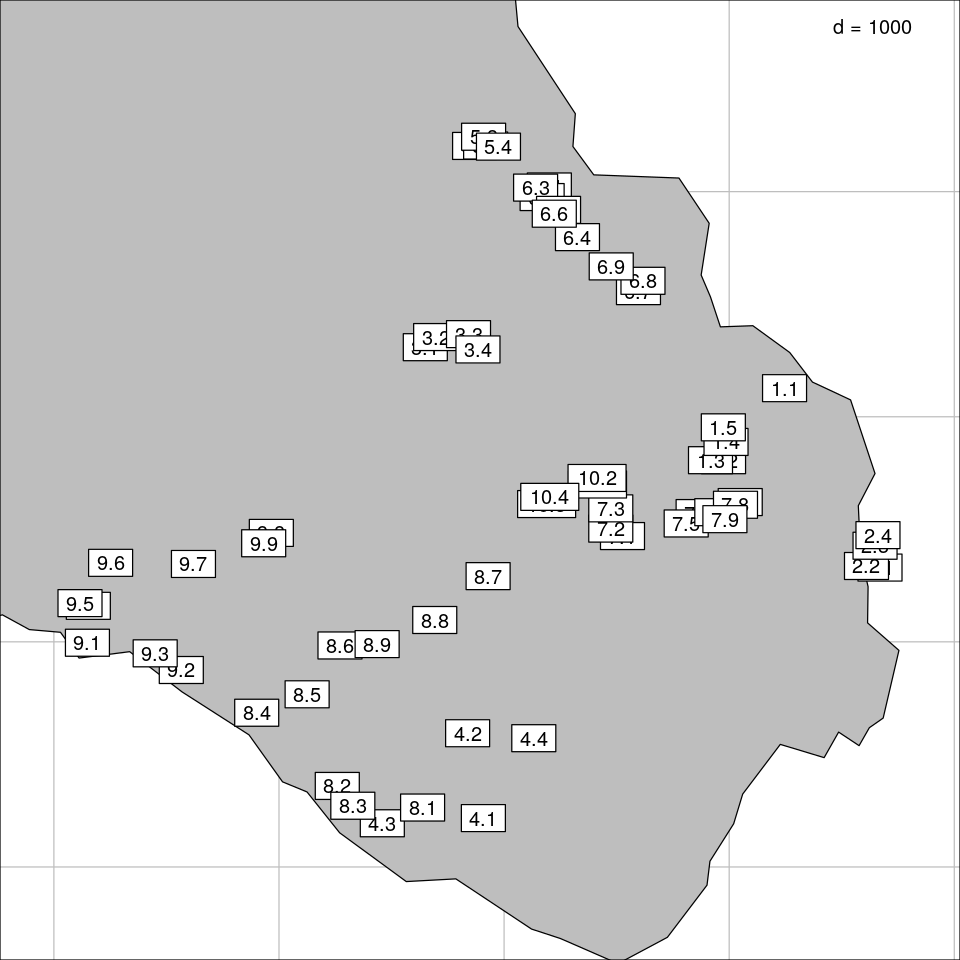

In [58]:
load('lcPoly.rda')
## sanity plot check:
s.label(pts[,2:3], labels=pts$PsubP, ppoint.col = "darkseagreen4", Sp = lcPoly)

Let's bring our points down to the axes. It seems to mess with the adegraphics plotting setup if we using the full UTM coordinates.

In [68]:
pJ <- as.matrix(pts[,2:3])
colnames(pJ) <- c('x','y')

mx <- min(pJ[,1])
my <- min(pJ[,2])
pJ <- cbind(pJ[,1] - mx, pJ[,2] - my)
rownames(pJ) <- pts$PsubP

Make our SWM:

In [69]:
## choose neighborhood type. "2" = gabriel:
nb <- chooseCN(coordinates(pJ), type = 2, plot.nb = FALSE)
## get the distances of each link:
distnb <- nbdists(nb, coordinates(pJ))
## weight them, by their length. Here a linear weighting:
fdist <- lapply(distnb, function(x) 1 - x/max(dist(pJ)))
## combine nb and fdist: 
lw <- nb2listw(nb, style = 'W', glist = fdist, zero.policy = TRUE)

We used a "Gabriel" method to construct our neighborhoods. Looks like this:

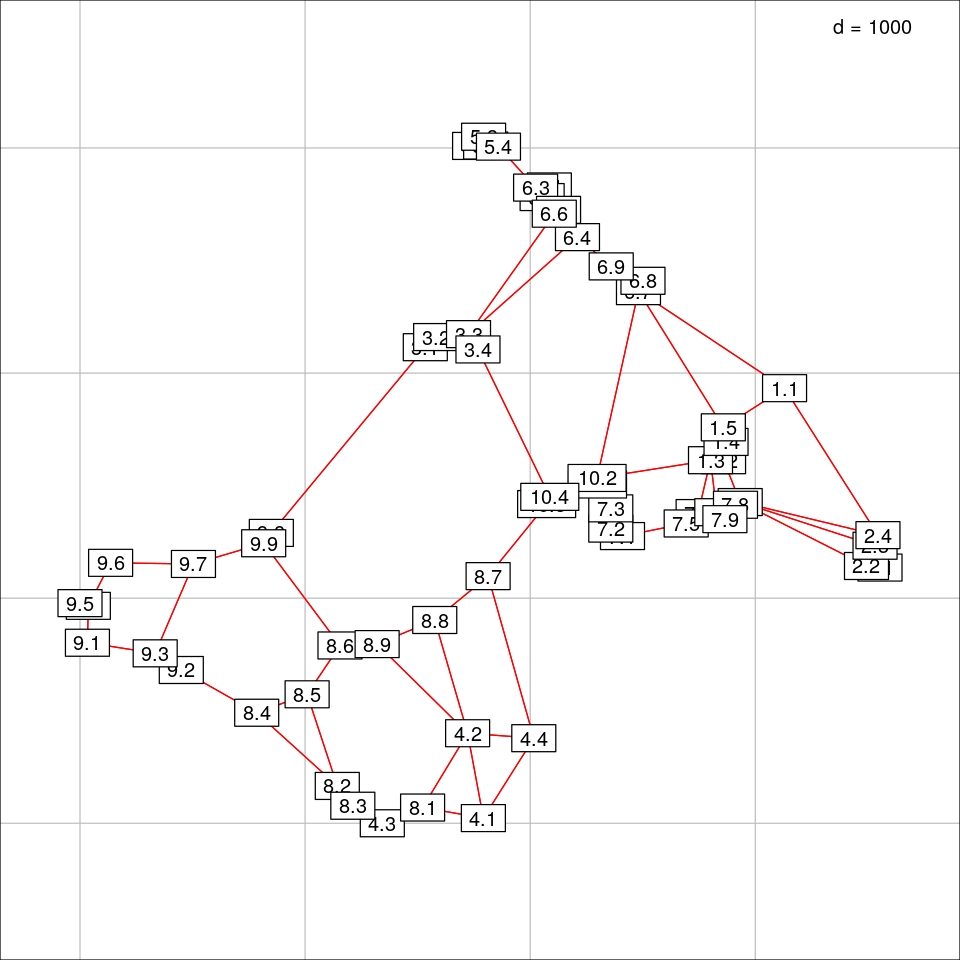

In [72]:
s.label(pJ, nb=nb, pnb.edge.col='red')

We weighted these links by distance, and now we can run the MEM construction on the weighted matrix of neighbors:

In [73]:
mem.lw <- mem(lw)

Take a look at some of them. They are constructed in order of "size", meaning the spatial scale that they can detect. 

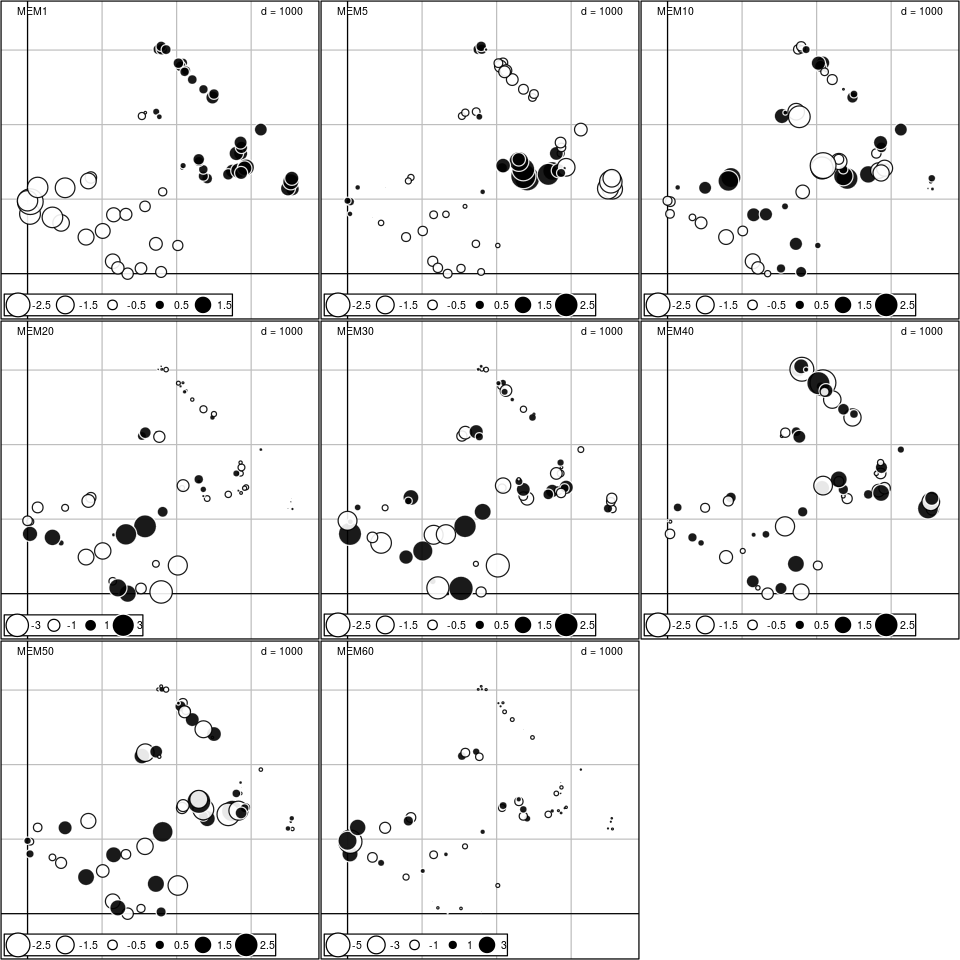

In [74]:
s.value(pJ, mem.lw[,c(1, 5, 10, 20, 30, 40, 50, 60)], symbol="circle")

There are almost as many of these MEMs as there are points on our map of plots. Right now they are meaningless, they are simply different patterns that could be useful, that we can test against our data. 

So we have to subset to ones that seem to reflect changes in space of our plant community. We need to do some model selection - running different combinations of the MEMs as models explaining changes in our community matrix, and finding only the ones that seem to explain some variance in our community, balanced by a need for simplicity (avoiding retaining too many MEMs to avoid overfitting). 

The best, currently-available tool for model-selection of MEMS is in the ade4 package, the "mem.select" function. It is frequentist, meaning that it first checks for global significance of the MEMS, with a default alpha cutoffs of 0.05, and with heavy penalties for multiple testing. This causes some small problems, it puts a sort of moral stop on checking out the individual MEMs as informative or not. But this is the tool that is available. 

First, we need to simplify our community matrix a bit, to use an explanatory variable to test the importance of our MEMS. We run a hellinger standardization and pick some important PCA axes out of this matrix:

In [75]:
comM.hell <- decostand(comM, 'hellinger')
pca.hell <- dudi.pca(df = comM.hell, scale = FALSE, scannf = FALSE, nf = 4)

We can check our MEMs against these new axes. 

In [76]:
mem.comM.sel <- mem.select(pca.hell$tab,
    method="FWD",
    listw = lw,
    nperm=9999,
    )

Procedure stopped (alpha criteria): pvalue for variable 14 is 0.111600 (> 0.050000)


In [77]:
mem.comM.sel$summary

,variables,order,R2,R2Cum,AdjR2Cum,pvalue
,<I<chr>>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,MEM2,2,0.04265480,0.04265480,0.02642861,0.0001
2,MEM1,1,0.04115028,0.08380508,0.05221215,0.0001
3,MEM8,8,0.03590965,0.11971473,0.07338392,0.0002
4,MEM10,10,0.03091845,0.15063318,0.08996412,0.0010
5,MEM3,3,0.03051204,0.18114522,0.10670387,0.0005
6,MEM12,12,0.02660190,0.20774712,0.11971902,0.0025
7,MEM5,5,0.02470054,0.23244766,0.13107282,0.0031
8,MEM9,9,0.02393299,0.25638065,0.14197767,0.0037
9,MEM13,13,0.02336687,0.27974752,0.15264414,0.0056


For the record, if we do try to relax this alpha?

In [79]:
mem.comM.sel.p20 <- mem.select(pca.hell$tab, method="FWD", listw = lw, alpha=0.2)

Procedure stopped (alpha criteria): pvalue for variable 14 is 0.130000 (> 0.050000)


In [80]:
mem.comM.sel.p20$summary

,variables,order,R2,R2Cum,AdjR2Cum,pvalue
,<I<chr>>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,MEM2,2,0.04265480,0.04265480,0.02642861,0.001
2,MEM1,1,0.04115028,0.08380508,0.05221215,0.001
3,MEM8,8,0.03590965,0.11971473,0.07338392,0.001
4,MEM10,10,0.03091845,0.15063318,0.08996412,0.001
5,MEM3,3,0.03051204,0.18114522,0.10670387,0.001
6,MEM12,12,0.02660190,0.20774712,0.11971902,0.006
7,MEM5,5,0.02470054,0.23244766,0.13107282,0.005
8,MEM9,9,0.02393299,0.25638065,0.14197767,0.007
9,MEM13,13,0.02336687,0.27974752,0.15264414,0.005


The alpha value cutoff parameter doesn't seem to change anything, the function throws out anything (global or individual with p>.05). Perhaps I will post about it somewhere and see if those brilliant french ecologists will get back to me.

Anyway, we can look at these MEMs that seem to reflect changes in the tree community. Let's get a polygon of los cedros to place in the background.

In [85]:
load('lcPoly.rda')
xx <- lcPoly@polygons[[1]]@Polygons[[1]]@coords[,'LCpolE']
yy <- lcPoly@polygons[[1]]@Polygons[[1]]@coords[,'LCpolN']
## the minimums of our sample sites was here:
pts <- read.csv('pts.csv')
pJ <- as.matrix(pts[,2:3])
colnames(pJ) <- c('x','y')
mx <- min(pJ[,1])
my <- min(pJ[,2])
pJ <- cbind(pJ[,1] - mx, pJ[,2] - my)
## transform our polygon points with these values?
xx <- xx - mx
yy <- yy - my
## and make a spatial polygon out of this?
lcPolyMoved <- SpatialPolygons(list(Polygons(list(Polygon(cbind(xx,yy))), ID="lcPolyMoved")))
#save(lcPolyMoved, file="lcPolyMoved.rda")

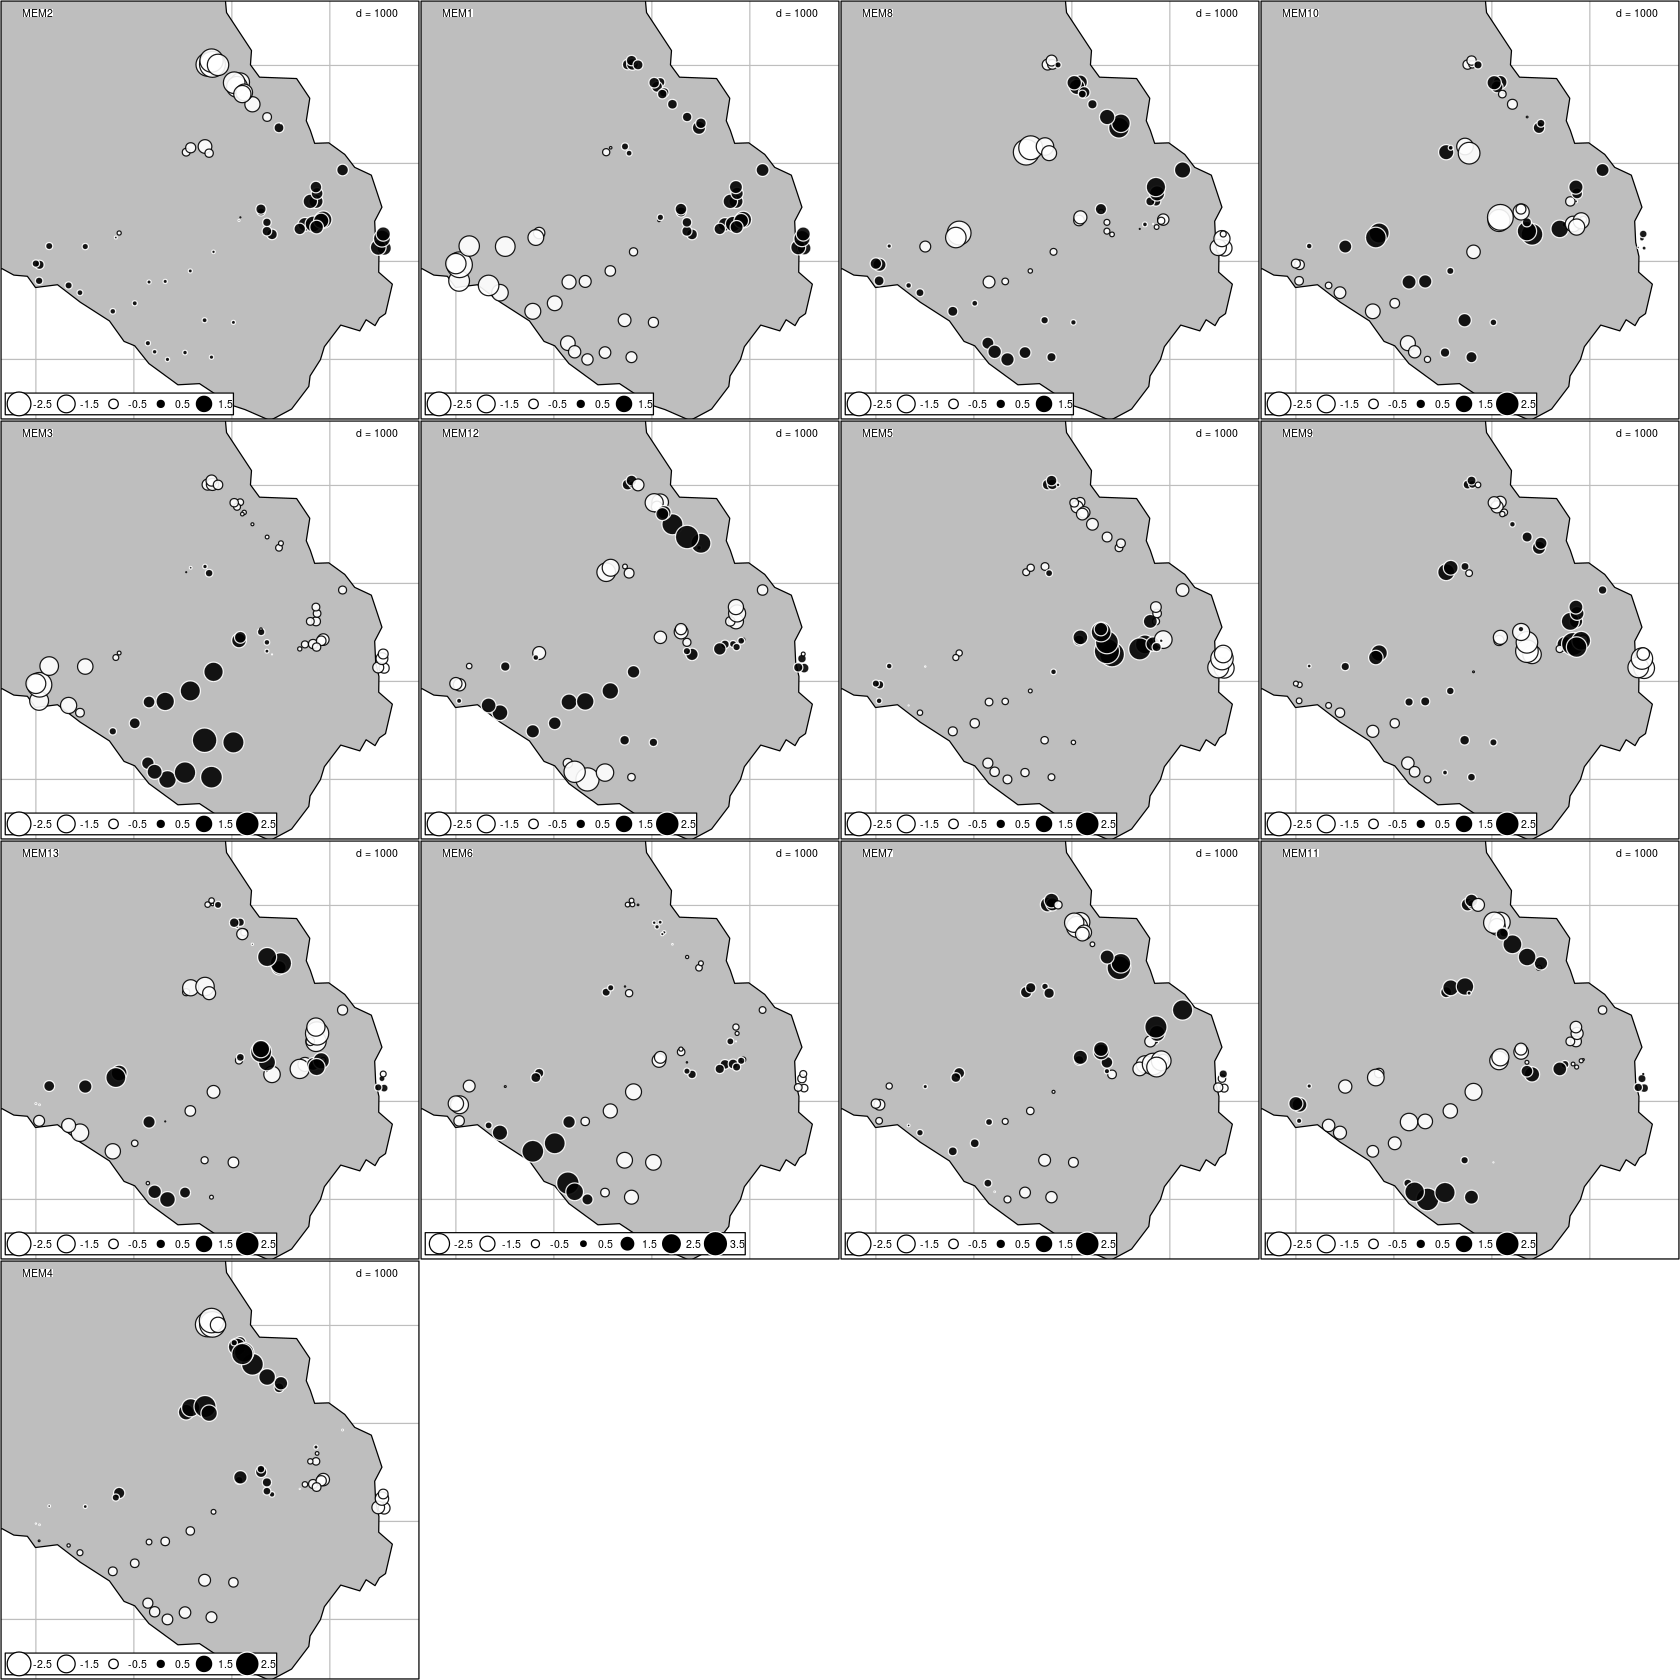

In [84]:
options(repr.plot.width=14, repr.plot.height=14)
s.value(pJ, mem.lw[,mem.comM.sel$summary$order], symbol="circle", Sp=lcPolyMoved)

[back to top](#contents)

<a id='ofs'></a>

### Old Forest Sites - a closer look

There is much evidence in the above analyses that the old forest sites are very similar, even among all three types - bosques cerrados (BC), bosques secondarios (BS), and claros del bosque (CLB). Let's subset to these and see if we can find differences/patterns.

In [3]:
library(vegan)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [ ]:
## make our old forest data:
oldF <- envOnly$habitat != 'RG' & envOnly$habitat != 'RCA'
load('cGroup.rda')
all(cGroup$PsubP == envOnly$PsubP)
envOnly$clGr <- cGroup$gr
oldForestEnv <-  envOnly[oldF,]
rownames(oldForestEnv) <- NULL
oldForestComm <- sPC[oldF,]
all(rownames(sPC) == envOnly$PsubP )
nonzs <- colSums(oldForestComm) != 0
oldForestComm <- oldForestComm[,nonzs]
all(oldForestEnv$PsubP == rownames(oldForestComm))
## spatial data:
oldForestSp <- read.csv("subParcelSpatial.csv")
oldForestSp <- oldForestSp[oldForestSp$PsubP %in% oldForestEnv$PsubP,]
all(oldForestSp$PsubP == oldForestEnv$PsubP)

#save(oldForestSp, file='oldForestSp.rda')
#save(oldForestComm, file="oldForestComm.rda")
#save(oldForestEnv, file="oldForestEnv.rda")

In [4]:
#load("oldForestComm.rda")
#load("oldForestEnv.rda")

In [76]:
## run test
bb <- adonis(oldForestComm ~ oldForestEnv$elevacion*oldForestEnv$habitat)  
bb


Call:
adonis(formula = oldForestComm ~ oldForestEnv$elevacion * oldForestEnv$habitat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                            Df SumsOfSqs MeanSqs F.Model
oldForestEnv$elevacion                       1    1.5845 1.58450  5.2158
oldForestEnv$habitat                         2    0.6300 0.31502  1.0369
oldForestEnv$elevacion:oldForestEnv$habitat  2    0.6416 0.32079  1.0560
Residuals                                   30    9.1137 0.30379        
Total                                       35   11.9698                
                                                 R2 Pr(>F)    
oldForestEnv$elevacion                      0.13237  0.001 ***
oldForestEnv$habitat                        0.05263  0.372    
oldForestEnv$elevacion:oldForestEnv$habitat 0.05360  0.333    
Residuals                                   0.76139           
Total                                       1.00000           
---
Si

If we subset to just the old forest sites (CLB, BS, BC), the permanova test cannot distinguish among habitat types. This makes sense, from the ordination above and the clustering results, there doesn't seem to be a large difference between gaps, closed forest, and recently regenerated gaps, given a constant elevation. They can almost be treated as the same habitat ("old forest"), as far as species composition. But within the old forest, elevation appears to be playing an important role. 

This begs the question, what is driving the separation of the old forest into two groups, as per our clustering results?

#### check differences among old forest subplots by habitat type

The results so far indicate that there isn't much difference among the habitat types of old forest sites (BC, BS, CLB), but we can do some more explicit tests of this here:

In [6]:
OFnms <- metaMDS(oldForestComm, try=40)

Wisconsin double standardization
Run 0 stress 0.285992 
Run 1 stress 0.2852565 
... New best solution
... Procrustes: rmse 0.04228528  max resid 0.1679529 
Run 2 stress 0.3082739 
Run 3 stress 0.2912187 
Run 4 stress 0.2867236 
Run 5 stress 0.3116426 
Run 6 stress 0.3014042 
Run 7 stress 0.2856956 
... Procrustes: rmse 0.01704692  max resid 0.07734838 
Run 8 stress 0.285992 
Run 9 stress 0.3070421 
Run 10 stress 0.2888253 
Run 11 stress 0.3085674 
Run 12 stress 0.2859733 
Run 13 stress 0.285992 
Run 14 stress 0.2910211 
Run 15 stress 0.2873738 
Run 16 stress 0.2915182 
Run 17 stress 0.2867365 
Run 18 stress 0.2872059 
Run 19 stress 0.2919664 
Run 20 stress 0.2939268 
Run 21 stress 0.2859283 
Run 22 stress 0.2973577 
Run 23 stress 0.2992125 
Run 24 stress 0.3044849 
Run 25 stress 0.298593 
Run 26 stress 0.2849566 
... New best solution
... Procrustes: rmse 0.01779067  max resid 0.08116275 
Run 27 stress 0.2953658 
Run 28 stress 0.3006526 
Run 29 stress 0.3011594 
Run 30 stress 0.2860718

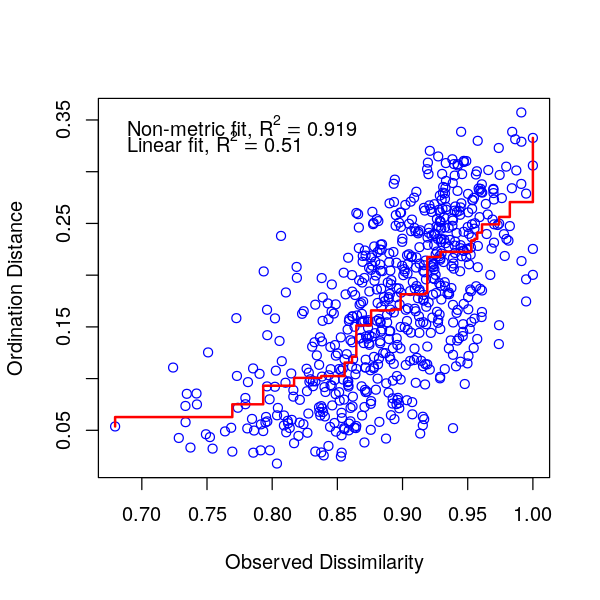

In [7]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(OFnms)
## as usual, not great, but still generally under 0.3

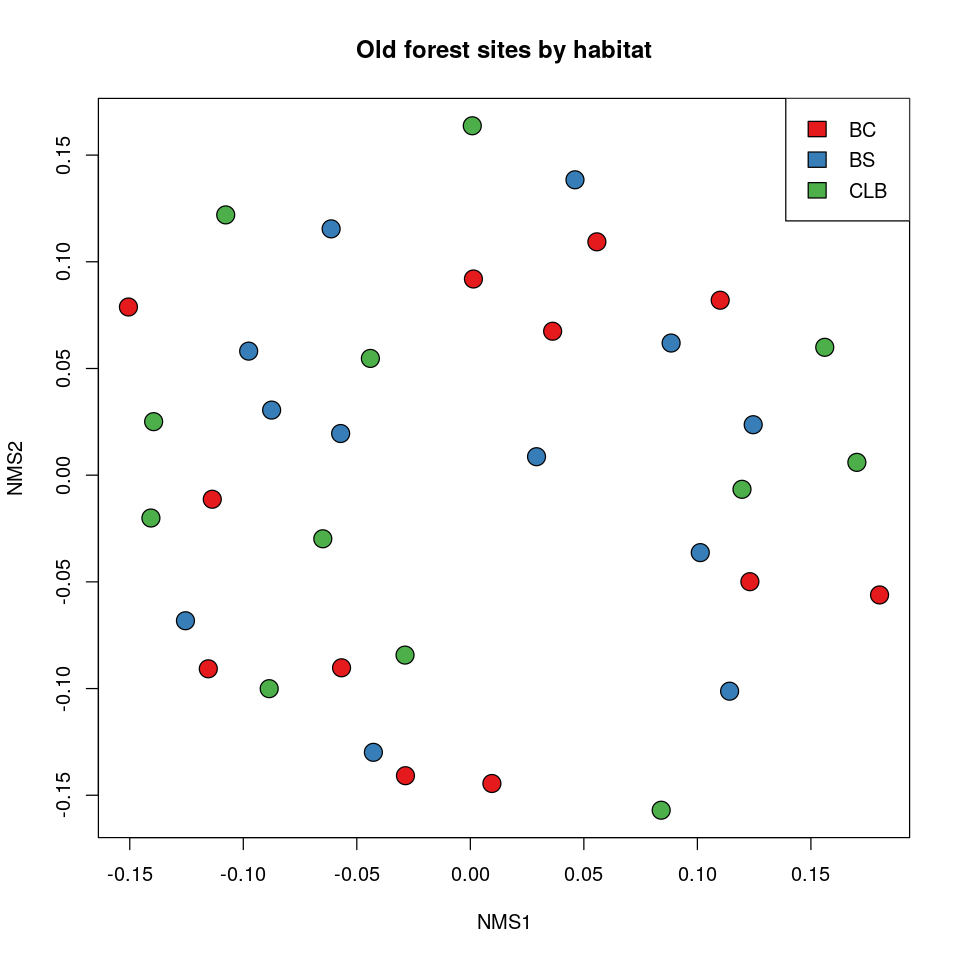

In [8]:
options(repr.plot.width=8, repr.plot.height=8)

XX <- OFnms$points[,'MDS1']
YY <- OFnms$points[,'MDS2']

## Get our colors to match original whole-community NMS:
colz <- vector()
for (i in oldForestEnv$habitat){
    if (i == 'BC'){colz <- c(colz, '#E41A1C')}
    if (i == 'BS'){colz <- c(colz, '#377EB8')}
    if (i == 'CLB'){colz <- c(colz, '#4DAF4A')}
}
plot(XX, YY,
    col="black",
    xlab='NMS1',
    ylab='NMS2',
    pch=21,
    cex=2,
    bg=colz,
    main="Old forest sites by habitat",
    )
legend( x='topright',
        legend = c('BC', 'BS', 'CLB'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A'),
        cex = 1.0,
        )


I'm not even going to try putting hulls on those groups. But to drive this home, we can model the dissilimarities as a function of habitat type:`

In [75]:
fh <- factor(oldForestEnv$habitat)
adonis(oldForestComm ~ fh)


Call:
adonis(formula = oldForestComm ~ fh) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
fh         2    0.6226 0.31132 0.90539 0.05202  0.653
Residuals 33   11.3472 0.34385         0.94798       
Total     35   11.9698                 1.00000       

The results are pretty much random. 

#### Ordinate forest sites by cluster

Our hierarchical clustering indicated at least two distinct forest types. Do these two types separate out clearly if we ordinate just the forest sites? If so, what are some environmental predictors of this?

In [9]:
OFnms <- metaMDS(oldForestComm, try=40)
XX <- OFnms$points[,'MDS1']
YY <- OFnms$points[,'MDS2']

Wisconsin double standardization
Run 0 stress 0.285992 
Run 1 stress 0.2856999 
... New best solution
... Procrustes: rmse 0.0366294  max resid 0.1550609 
Run 2 stress 0.2858908 
... Procrustes: rmse 0.03408196  max resid 0.1593632 
Run 3 stress 0.2849097 
... New best solution
... Procrustes: rmse 0.02436452  max resid 0.08958909 
Run 4 stress 0.2859742 
Run 5 stress 0.2849574 
... Procrustes: rmse 0.005015819  max resid 0.02442536 
Run 6 stress 0.2905362 
Run 7 stress 0.3208542 
Run 8 stress 0.3031141 
Run 9 stress 0.3014191 
Run 10 stress 0.2908548 
Run 11 stress 0.2911979 
Run 12 stress 0.2852641 
... Procrustes: rmse 0.01843935  max resid 0.08248808 
Run 13 stress 0.2857156 
Run 14 stress 0.2858908 
Run 15 stress 0.2861552 
Run 16 stress 0.3068646 
Run 17 stress 0.2905368 
Run 18 stress 0.2907439 
Run 19 stress 0.2956598 
Run 20 stress 0.2974809 
Run 21 stress 0.3048784 
Run 22 stress 0.2951341 
Run 23 stress 0.2939636 
Run 24 stress 0.2858908 
Run 25 stress 0.2912062 
Run 26 stre

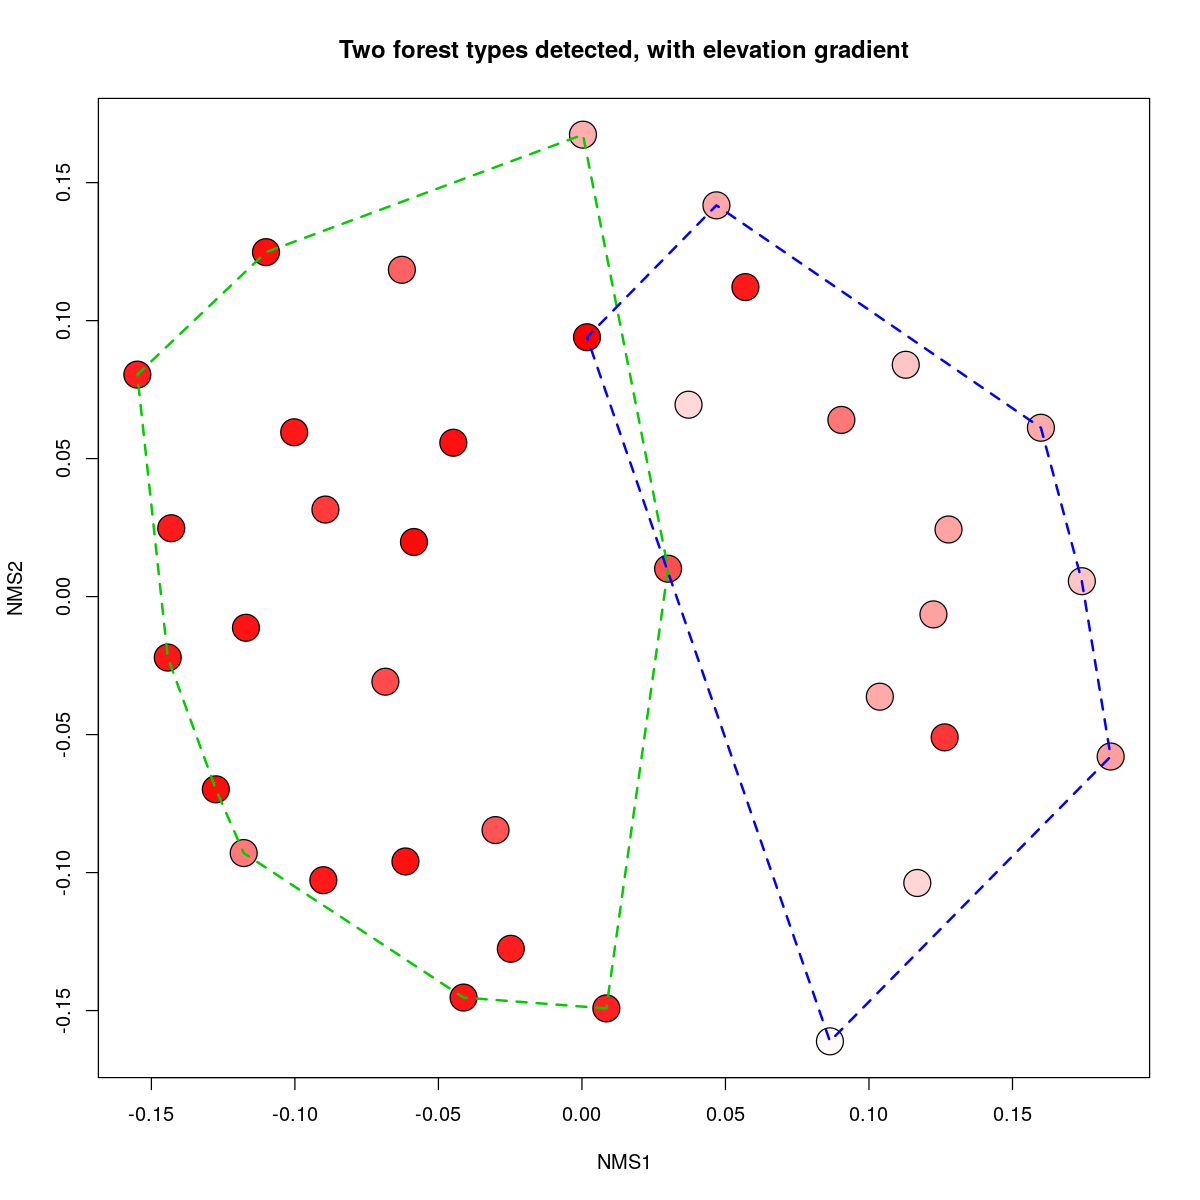

In [10]:
options(repr.plot.width=10, repr.plot.height=10)

## make a color ramp for this elevation data
minElev <- min(oldForestEnv$elevacion)
maxElev <- max(oldForestEnv$elevacion)
rangeElev <- maxElev - minElev
colrsRamp <- colorRampPalette(c(rgb(1,0,0,0), rgb(1,0,0,1)), alpha = TRUE)(rangeElev)
ElevColrs <- colrsRamp[oldForestEnv$elevacion - min(oldForestEnv$elevacion)]

plot(XX, YY,
    col="black",
    pch=21,
    cex=3,
    bg=ElevColrs,
    xlab='NMS1',
    ylab='NMS2',
    main="Two forest types detected, with elevation gradient"
    )
## can we add cluster group data to the plot?
## group order will be:
#names(table(oldForestEnv$clGr))
## so this should work:
ordihull(OFnms, oldForestEnv$clGr, col=c(3,4), lwd=2, lty=2)
## yup, that's intriguing. 
#legend( x='topright',
#        legend = c('clustGroup 3', 'clustGroup 4', '1259 m', '1680 m'),
#        col = c(3,4, 1, 1),
#        bty = 'n',
#        pt.bg = c(NA, NA, "transparent", "red"),
#        #merge = FALSE,
#        cex = 2.0,
#        lty = c(2,2, NA, NA),
#        lwd = 2.0,
#        pch = c(NA, NA, 21, 21),
#        )


I am still having troubles with getting the jupyter plotter to handle my legends. From my local plotter:

<img src="oldForestNMSelevClust.png" width=500>

It's pretty clear that there is an elevation difference. Cluster group 3 tends to higher sites, group 4 to lower. There may be other indicators, such as proximity to streams or location (particular watersheds may harbor unique species), so more work is needed here. 

[back to top](#contents)